**Author:** Summer </br>
**Task:** 2D footprint clustering (exterior boundaries of building footprints)

***Taking spatial attributes into account by computing:***
- ***node weights - the radius of nodes from the polygon boundary.***
- ***edge weights - the Euclidean distance between vertices***

## PART I: Skeleton Graph Computation
### **Step 1: Medial Axis Approximation (Approach 4 Point reduction and edge construction in step 1, scikit geometry in step 2)**

**1.1 Load data, plot edges and points of each building footprint**

In [1]:
# import library
import sys
sys.path.append('./WWL/src')
from wwl import wwl
import igraph as ig

import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
from shapely.ops import unary_union
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import wasserstein_distance
import ot
import skgeom as sg
from skgeom.draw import draw

In [2]:
# simplified shp in QGIS using the simplify tool
# dissovled boundaries to obtain exterior boundary of each footprint
# load simplified shp
sim_buildings_ext_gdf = gpd.read_file("./data/output/sim_buildings_ext_boundary_diss.shp")
sim_buildings_ext_gdf

,blockID,stories,materials,geometry
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24..."
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9..."
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5..."
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2..."
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24..."
...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4..."
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1..."
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80..."
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1..."


In [3]:
sim_buildings_ext_gdf.explore(tiles='CartoDB Positron')

In [4]:
# placing points on the vertices where an edge changes direction, constructing edges between vertices
def sample_points_at_vertices(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    all_vertex_points = []
    all_edges = []

    for idx, row in gdf.iterrows():
        geom = row.geometry # extracts the geometry (i.e., building footprint) from the row in the gdf

        # skip any rows without geometry or with a geometry that is not a polygon or multipolygon, null geometries
        if geom is None or not isinstance(geom, (Polygon, MultiPolygon)):
            print(idx)
            print(geom)
            continue

        # if the geometry is a multipolygon, merge them into a single polygon
        if isinstance(geom, MultiPolygon):
            geom = unary_union(geom)

        exterior_coords = list(geom.exterior.coords) # get the coordinates of the outer boundary of the polygon, in a sequence of (x,y) tuples
        coords = exterior_coords[:-1]
        vertex_points = [Point(xy) for xy in exterior_coords[:-1]]  # convert each (x,y) coordinate into a Point object, exclude the last coordinate since it duplicates the first (to close the polygon)
        all_vertex_points.extend(vertex_points) # add all the Point objects of a polygon to the list all_vertex_points

        # Create edges between consecutive vertices
        edges = [LineString([coords[i], coords[i + 1]]) for i in range(len(coords) - 1)]
        # Add edge between the last and first to close the polygon
        edges.append(LineString([coords[-1], coords[0]]))

        all_edges.extend(edges)

    # Return GeoDataFrames for points and edges
    points_gdf = gpd.GeoDataFrame(geometry=all_vertex_points, crs=gdf.crs)
    edges_gdf = gpd.GeoDataFrame(geometry=all_edges, crs=gdf.crs)

    return gdf, points_gdf, edges_gdf

In [5]:
# load building footprint for cleaning - ext boundaries
sim_buildings_ext_gdf, sim_points_ext_gdf, sim_edges_ext_gdf = sample_points_at_vertices("./data/output/sim_buildings_ext_boundary_diss.shp")

**1.2 Medial axis construction using scikit-geometry**

In [6]:
def draw_skeleton(polygon, skeleton, show_time=False):
    draw(polygon)

    for h in skeleton.halfedges:
        if h.is_bisector:
            p1 = h.vertex.point
            p2 = h.opposite.vertex.point
            plt.plot([p1.x(), p2.x()], [p1.y(), p2.y()], 'r-', lw=2)

    if show_time:
        for v in skeleton.vertices:
            plt.gcf().gca().add_artist(plt.Circle(
                (v.point.x(), v.point.y()),
                v.time, color='blue', fill=False))

def draw_all_skeletons(polygon, all_skeletons, show_time=False, figsize=(24,24)):
    plt.figure(figsize=figsize)
    draw(polygon, line_width=0.5)
    
    for item in all_skeletons:

        if item is None:
            continue
        
        for h in item.halfedges:
            if h.is_bisector:
                p1 = h.vertex.point
                p2 = h.opposite.vertex.point
                plt.plot([p1.x(), p2.x()], [p1.y(), p2.y()], 'r-', lw=0.5)

        if show_time:
            for v in skeleton.vertices:
                plt.gcf().gca().add_artist(plt.Circle(
                    (v.point.x(), v.point.y()),
                    v.time, color='blue', fill=False))
    return plt

In [7]:
all_poly = []
all_skeleton = []

for idx, row in sim_buildings_ext_gdf.iterrows():
    geom = row.geometry
    #print(geom)

    # skip any rows without geometry or with a geometry that is not a polygon or multipolygon, null geometries
    if geom is None or not isinstance(geom, (Polygon, MultiPolygon)): 
        print(idx)
        print(geom)
        continue

    # continue to work with geom that is not null
    # for each geom, extract the points and convert them to sg.Point2; use the points to create and draw poly; create the skeleton for each geom
    points = []
    for x,y in geom.boundary.coords[:-1]: # [:-1] to exclude the last point that is used to close the polygon
        points.append(sg.Point2(x,y))
         
    poly = sg.Polygon(points[::-1]) # reverse order of the points    
    all_poly.append(poly)
    skel = sg.skeleton.create_interior_straight_skeleton(poly)        
    all_skeleton.append(skel)

In [8]:
for idx, x in enumerate(all_skeleton):
    if x == None:
        print(idx, x)

<module 'matplotlib.pyplot' from '/home/summerha/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

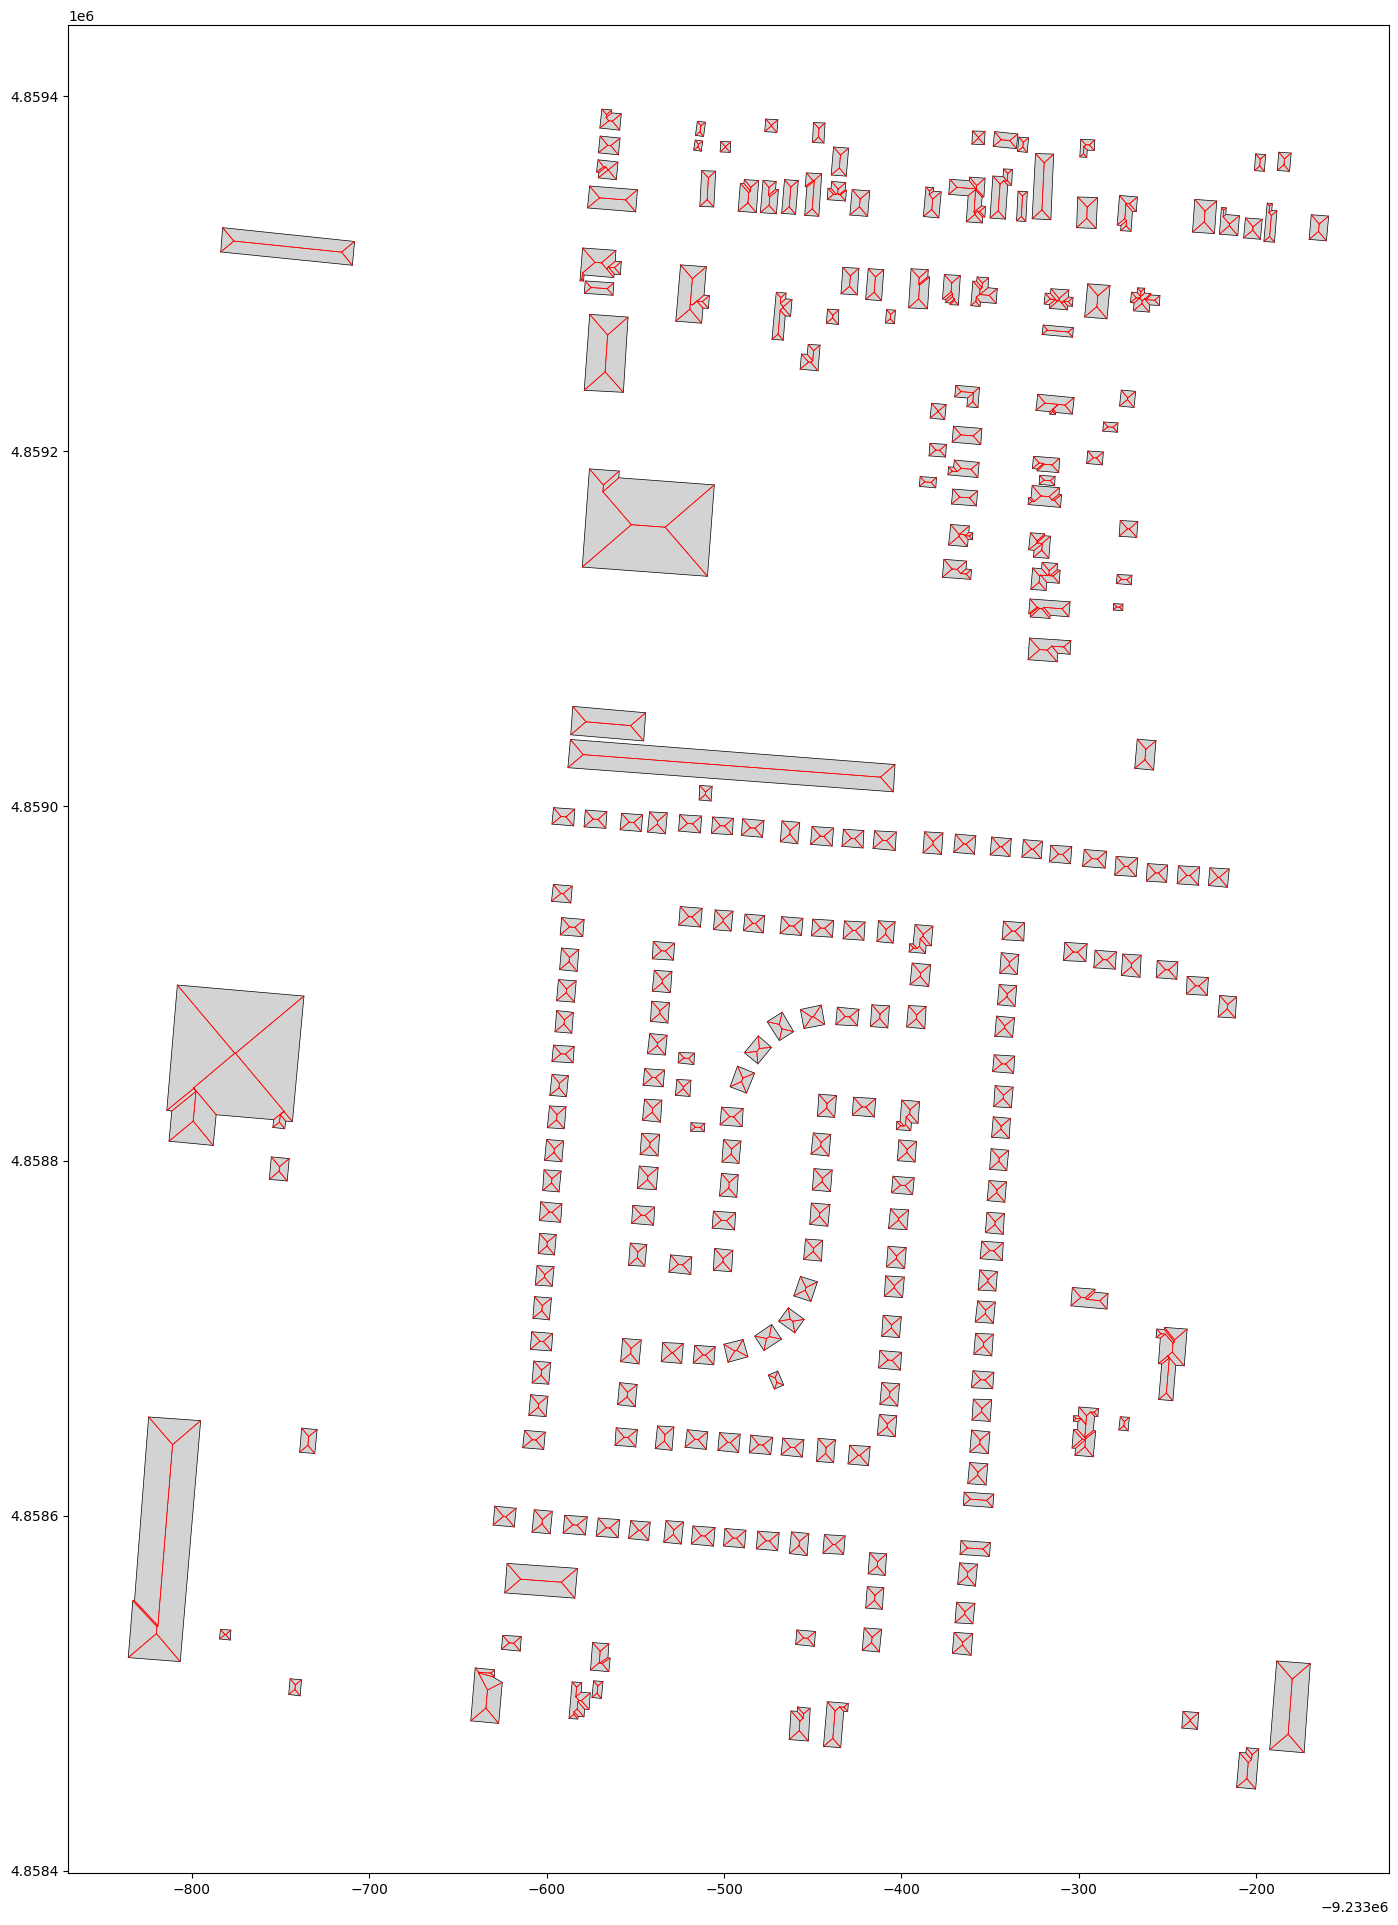

In [9]:
draw_all_skeletons(all_poly,all_skeleton)

In [10]:
all_skeleton

## PART II: Clustering

### **Step 1: Graph Embedding - From skeleton to graph features**

**2.1 Compute the weight/distance of vertices for each medial axis***

In [11]:
import math

all_weights = []
for skeleton in all_skeleton:
    weights = {}
    for edge in skeleton.halfedges:
        if edge.is_bisector:
            u1_pt = edge.vertex.point
            u2_pt = edge.opposite.vertex.point
            u1_vertex = edge.vertex
            u2_vertex = edge.opposite.vertex
            d_u1u2 = math.sqrt((u2_pt.x()-u1_pt.x())**2 + (u2_pt.y()-u1_pt.y())**2)
            weights[(u1_vertex.id, u2_vertex.id)] = d_u1u2 
    all_weights.append(weights)


all_weights

[{(16, 0): 20.86054168191052,
  (0, 16): 20.86054168191052,
  (16, 1): 20.75550146816766,
  (1, 16): 20.75550146816766,
  (15, 2): 20.85750635752731,
  (2, 15): 20.85750635752731,
  (15, 3): 20.649620768672616,
  (3, 15): 20.649620768672616,
  (12, 4): 19.310792836325223,
  (4, 12): 19.310792836325223,
  (17, 5): 19.947078641840353,
  (5, 17): 19.947078641840353,
  (15, 12): 102.35187813777371,
  (12, 15): 102.35187813777371,
  (17, 12): 0.73485906380515,
  (12, 17): 0.73485906380515,
  (17, 16): 3.941996533980612,
  (16, 17): 3.941996533980612},
 {(8, 0): 3.8908917212530487,
  (0, 8): 3.8908917212530487,
  (9, 1): 3.979314853917128,
  (1, 9): 3.979314853917128,
  (9, 2): 3.912162022100991,
  (2, 9): 3.912162022100991,
  (8, 3): 3.8707122480256837,
  (3, 8): 3.8707122480256837,
  (9, 8): 0.4378839027093938,
  (8, 9): 0.4378839027093938},
 {(8, 0): 9.592372510200464,
  (0, 8): 9.592372510200464,
  (8, 1): 9.477622524738061,
  (1, 8): 9.477622524738061,
  (9, 2): 9.828968775352473,
  (2,

**2.2 Compute node features**

According to [Duong et al. (2023)](https://doi.org/10.1145/3615900.3628790), node features denotes the radius of the corresponding node of the medial axis transform for all $v \in V$.

First, convert networkx graphs to igraph graphs. Refer to documentation here.

In [12]:
### function #2: Convert skeleton graphs to networkx graphs
def skeleton2igraph(skeleton):
    geom_vertices = list(skeleton.vertices)
    geom_edges = list(skeleton.halfedges)

    # create an empty graph with no nodes and no edges
    G=nx.Graph()

    # grow undirected (since it adds up from both direction) graph G by adding edge, done by specifying the vertex id at two ends to determine the edge
    for item in geom_edges:
        if item.is_bisector:
            p1 = item.vertex.id # vertex id
            p2 = item.opposite.vertex.id
            G.add_edge(p1, p2)
    #nx.draw(G, with_labels=True)
    igraph = ig.Graph.from_networkx(G)
    return igraph

In [13]:
all_igraphs = []

for i in all_skeleton:
    all_igraphs.append(skeleton2igraph(i))

all_igraphs

In [14]:
len(all_igraphs)

253

Secondly, embed the graphs into a node feature. The node feature needs to be a list of dictionary.

In [15]:
all_node_ls_dict = []
for skeleton in all_skeleton:
    node_ls_dict = {}
    for i in list(skeleton.vertices):
        node_ls_dict[i.id] = i.time
    all_node_ls_dict.append(node_ls_dict)

all_node_ls_dict

[{0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  12: 14.242870092967763,
  15: 14.645540455197322,
  16: 14.728727658714066,
  17: 14.736970654916865},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 2.76358492677836, 9: 2.769821227779974},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 6.747976774744137, 9: 6.858177803181223},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  14: 2.0255263887972346,
  15: 2.1027296110401936,
  18: 2.332117013741329,
  19: 7.920892516114367,
  20: 7.940983367177611},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 4.025856252785827, 9: 4.0642355501811585},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  20: 2.5427346161882536,
  21: 2.573588385916939,
  24: 2.769327582240554,
  25: 2.8092298404182663,
  28: 4.161179432337649,
  31: 4.168435987164082,
  32: 4.728925484345941,
  33: 4.750738116667312},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  12: 4.253664165210792,
  13: 4.4084

### **Step 2: Continuous Weisfeiler-Lehman and Wasserstein Distance Computation**

In [16]:
# compute the kernel
kernel_matrix = wwl(all_igraphs,node_features=all_node_ls_dict, edge_weight=all_weights, num_iterations=4)

INFO:root:Continuous node features provided, using CONTINUOUS propagation scheme.


weighted_label_sequences: [array([[ 0.        ,  7.36436383, 10.03624545, 11.29596914, 12.02339296],
       [ 0.        ,  7.36436383, 10.03624545, 11.29596914, 12.02339296],
       [ 0.        ,  7.32277023,  7.65053024,  7.80928159,  7.95802599],
       [ 0.        ,  7.32277023,  7.65053024,  7.80928159,  7.95802599],
       [ 0.        ,  7.12143505, 10.67138678, 12.39281574, 13.1958923 ],
       [ 0.        ,  7.36848533, 10.84047652, 12.44444226, 13.17885686],
       [14.24287009, 14.22133851, 14.11424469, 13.99896886, 13.90849971],
       [14.64554046,  7.97829026,  7.96803294,  8.10677039,  8.24290284],
       [14.72872766, 12.70812707, 12.55569283, 12.75081677, 12.97245123],
       [14.73697065, 14.3124677 , 14.04840801, 13.91327145, 13.83760577]]), array([[0.        , 1.38179246, 1.94675392, 2.17803796, 2.27280539],
       [0.        , 1.38491061, 1.95030653, 2.18083711, 2.2747461 ],
       [0.        , 1.38491061, 1.95030653, 2.18083711, 2.2747461 ],
       [0.        , 1.38

In [17]:
kernel_matrix

array([[1.00000000e+00, 2.11881266e-03, 2.19801952e-03, ...,
        4.63618069e-01, 1.09597154e-03, 1.19621331e-03],
       [2.11881266e-03, 1.00000000e+00, 4.85020471e-01, ...,
        1.03895972e-03, 3.64620766e-01, 3.91058117e-01],
       [2.19801952e-03, 4.85020471e-01, 1.00000000e+00, ...,
        1.07155465e-03, 4.76453430e-01, 5.22975157e-01],
       ...,
       [4.63618069e-01, 1.03895972e-03, 1.07155465e-03, ...,
        1.00000000e+00, 5.34296162e-04, 5.83164945e-04],
       [1.09597154e-03, 3.64620766e-01, 4.76453430e-01, ...,
        5.34296162e-04, 1.00000000e+00, 9.07749974e-01],
       [1.19621331e-03, 3.91058117e-01, 5.22975157e-01, ...,
        5.83164945e-04, 9.07749974e-01, 1.00000000e+00]], shape=(253, 253))

### **Step 3: Spectral Clustering**

In [18]:
# construct laplacian matrix, L = D - A
# compute D
D = np.diag(kernel_matrix.sum(axis=1))
print(D)

[[  2.08172535   0.           0.         ...   0.           0.
    0.        ]
 [  0.         119.68710984   0.         ...   0.           0.
    0.        ]
 [  0.           0.         127.96751806 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   2.10494685   0.
    0.        ]
 [  0.           0.           0.         ...   0.         183.06769637
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  183.12440434]]


**3.1 Laplacian Matrix**

In [19]:
# compute L
L = D - kernel_matrix
print(L)

[[ 1.08172535e+00 -2.11881266e-03 -2.19801952e-03 ... -4.63618069e-01
  -1.09597154e-03 -1.19621331e-03]
 [-2.11881266e-03  1.18687110e+02 -4.85020471e-01 ... -1.03895972e-03
  -3.64620766e-01 -3.91058117e-01]
 [-2.19801952e-03 -4.85020471e-01  1.26967518e+02 ... -1.07155465e-03
  -4.76453430e-01 -5.22975157e-01]
 ...
 [-4.63618069e-01 -1.03895972e-03 -1.07155465e-03 ...  1.10494685e+00
  -5.34296162e-04 -5.83164945e-04]
 [-1.09597154e-03 -3.64620766e-01 -4.76453430e-01 ... -5.34296162e-04
   1.82067696e+02 -9.07749974e-01]
 [-1.19621331e-03 -3.91058117e-01 -5.22975157e-01 ... -5.83164945e-04
  -9.07749974e-01  1.82124404e+02]]


**3.2 K-mean Clustering**

- ***Eigengap heuristic for finding the optimal number of clusters***

This paper by [von Luxburg (2007)](https://link.springer.com/content/pdf/10.1007/s11222-007-9033-z.pdf) proposes an approach based on perturbation theory and spectral graph theory to calculate the optimal number of clusters. Eigengap heuristic suggests the number of clusters *k* is usually given by the value of *k* that maximizes the eigengap (difference between consecutive eigenvalues). The larger this eigengap is, the closer the eigenvectors of the ideal case and hence the better spectral clustering works.

References for implementing the code below: [Spectral graph clustering and optimal number of clusters estimation](https://medium.com/data-science/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe).

In [20]:
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

In [21]:
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.xlim(0, 10)  # Set x-axis to show from 1 to 10
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

Optimal number of clusters: [  2 252   1 251   3]


/tmp/ipykernel_2350/3834166893.py:27: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)


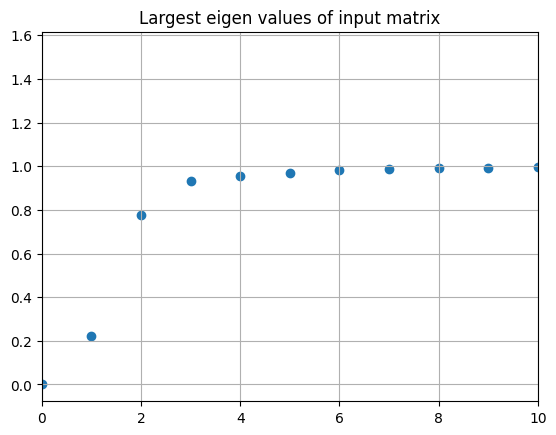

In [22]:
k, _, _ = eigenDecomposition(kernel_matrix)
print(f"Optimal number of clusters: {k}")

- ***Clustering***

In [23]:
from sklearn.cluster import SpectralClustering

- *n*=2

In [24]:
# n = 2
clsutering_2 = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(kernel_matrix)
y_pred_2 = clsutering_2.labels_.astype(int)
sim_buildings_ext_gdf['cluster_2'] = y_pred_2
sim_buildings_ext_gdf['cluster_2'] = sim_buildings_ext_gdf['cluster_2'].astype('category') # Make the column categorical
sim_buildings_ext_gdf

,blockID,stories,materials,geometry,cluster_2
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",1
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",0
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",0
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",0
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",0
...,...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",0
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",0
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",1
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1...",0


Text(0.5, 1.0, 'Building Clusters (k=2)')

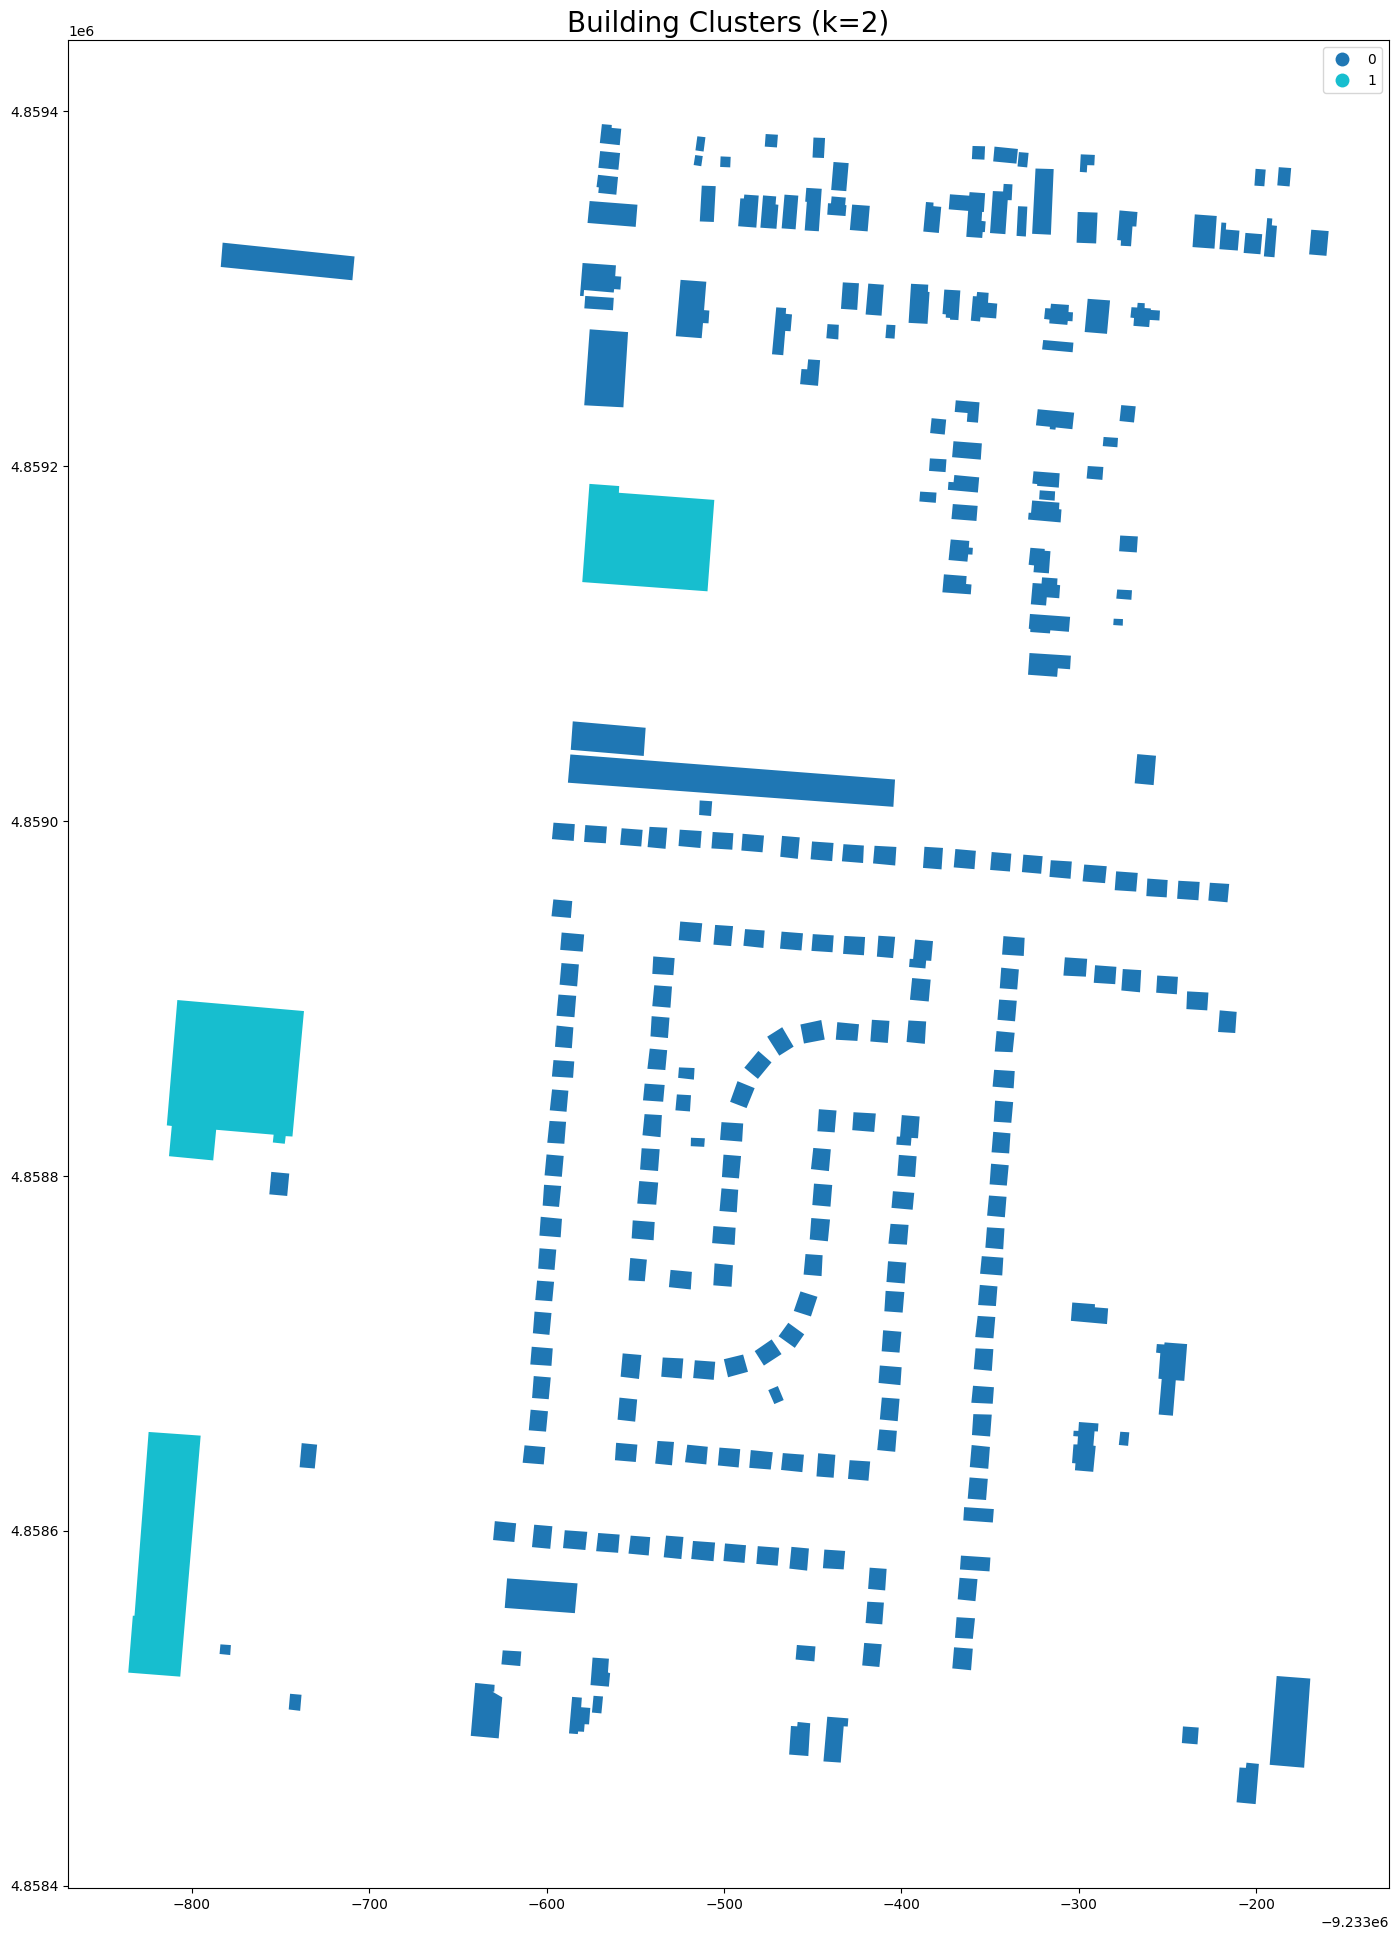

In [25]:
sim_buildings_ext_gdf.plot(column='cluster_2', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=2)", fontsize=20)

- *n*=3

In [26]:
# n = 3
clsutering_3 = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(kernel_matrix)
y_pred_3 = clsutering_3.labels_.astype(int)
sim_buildings_ext_gdf['cluster_3'] = y_pred_3
sim_buildings_ext_gdf['cluster_3'] = sim_buildings_ext_gdf['cluster_3'].astype('category') # Make the column categorical
sim_buildings_ext_gdf

,blockID,stories,materials,geometry,cluster_2,cluster_3
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",1,2
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",0,0
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",0,0
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",0,0
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",0,0
...,...,...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",0,0
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",0,0
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",1,1
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1...",0,0


Text(0.5, 1.0, 'Building Clusters (k=3)')

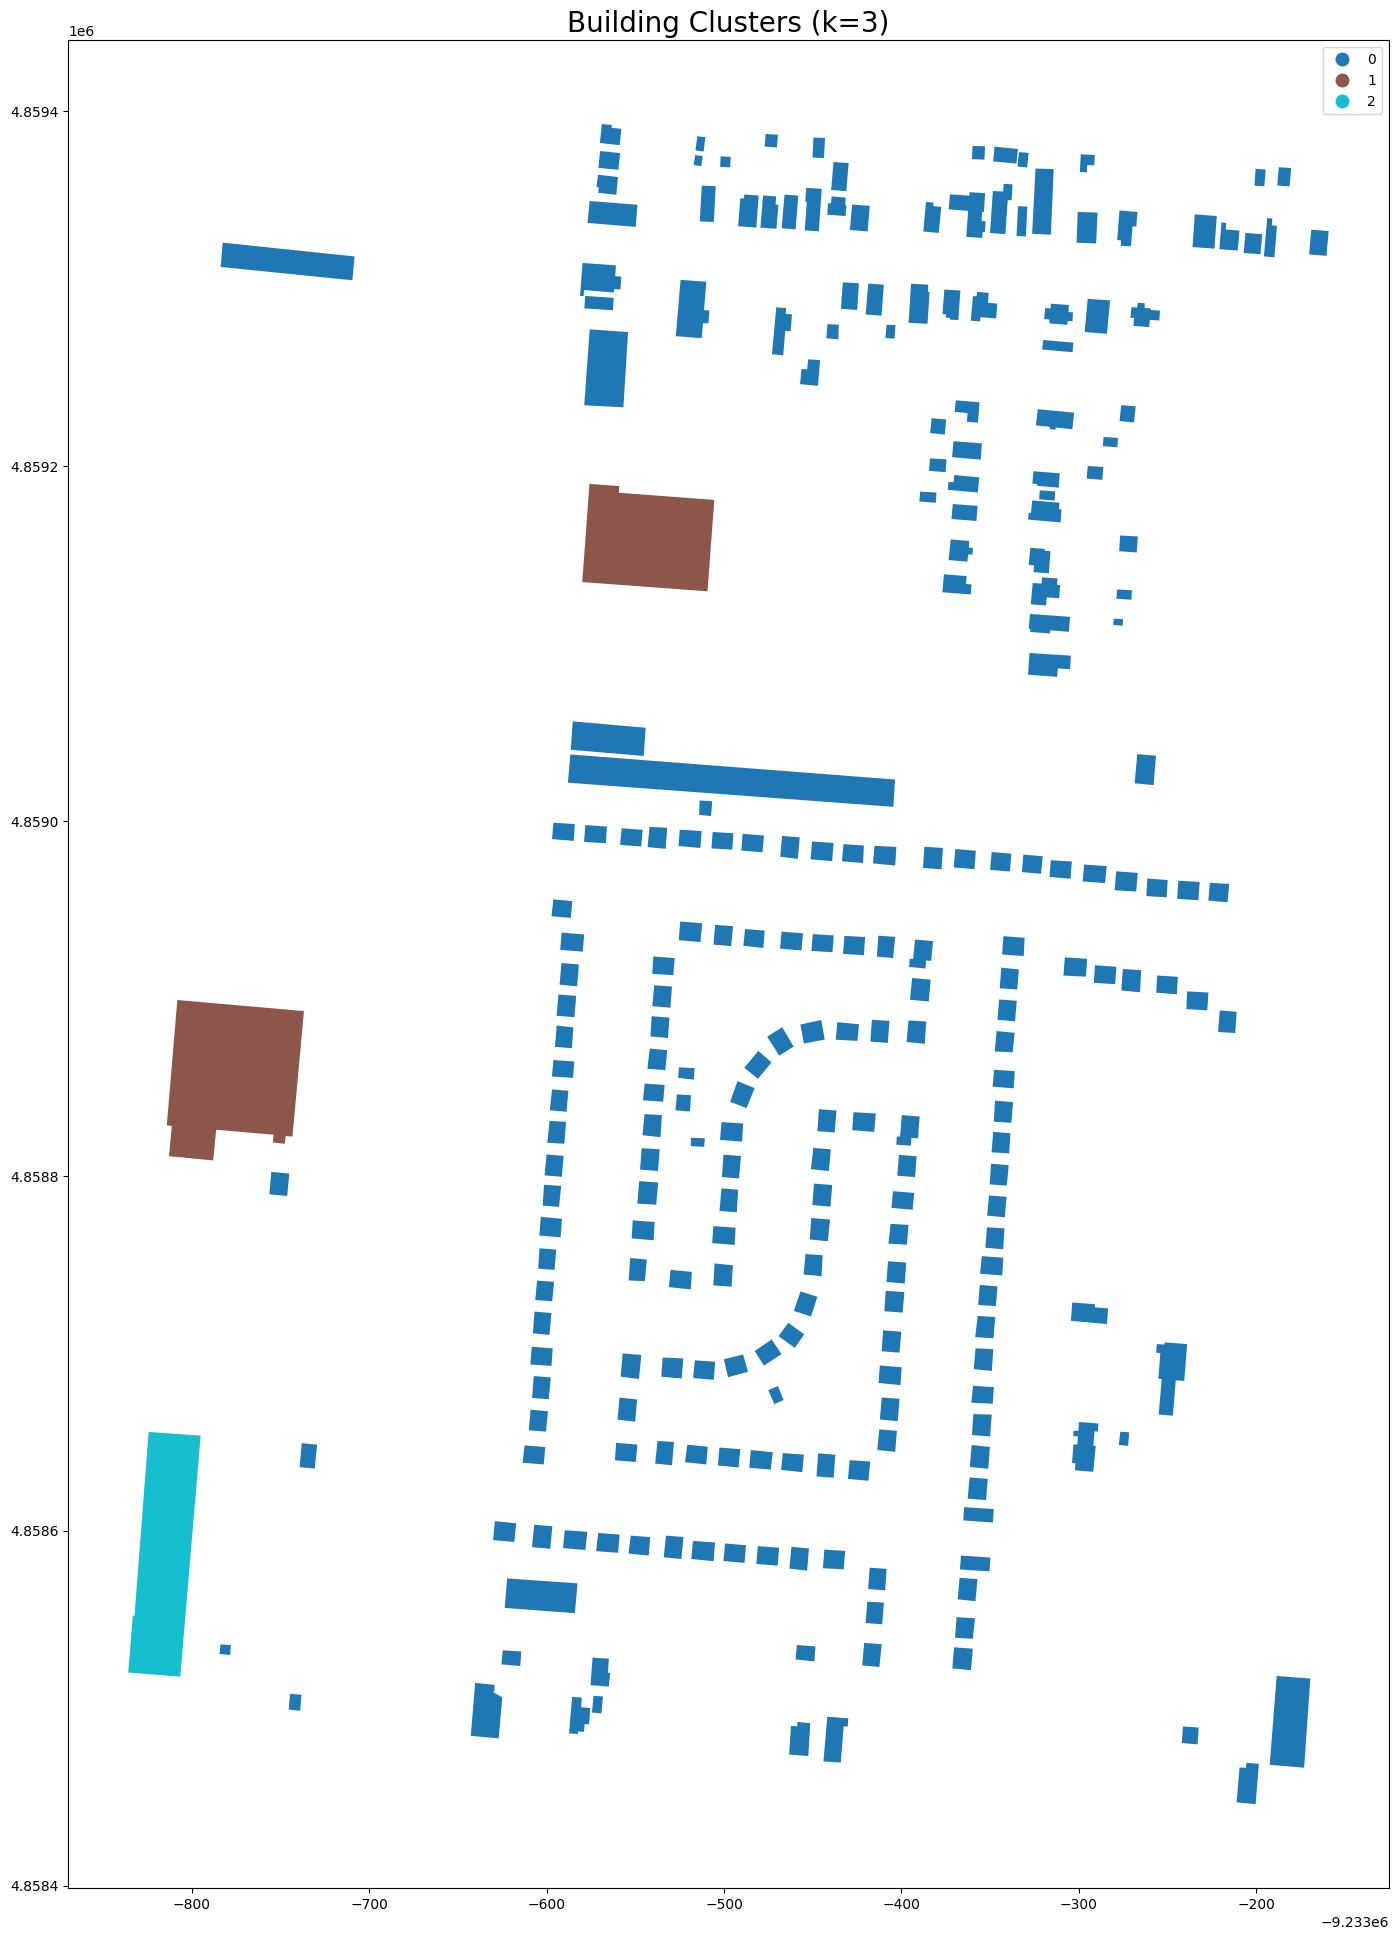

In [27]:
sim_buildings_ext_gdf.plot(column='cluster_3', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=3)", fontsize=20)

- *n*=4

In [28]:
# n = 4
clsutering_4 = SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(kernel_matrix)
y_pred_4 = clsutering_4.labels_.astype(int)
sim_buildings_ext_gdf['cluster_4'] = y_pred_4
sim_buildings_ext_gdf['cluster_4'] = sim_buildings_ext_gdf['cluster_4'].astype('category') # Make the column categorical
sim_buildings_ext_gdf

,blockID,stories,materials,geometry,cluster_2,cluster_3,cluster_4
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",1,2,3
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",0,0,2
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",0,0,0
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",0,0,2
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",0,0,0
...,...,...,...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",0,0,0
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",0,0,0
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",1,1,1
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1...",0,0,0


Text(0.5, 1.0, 'Building Clusters (k=4)')

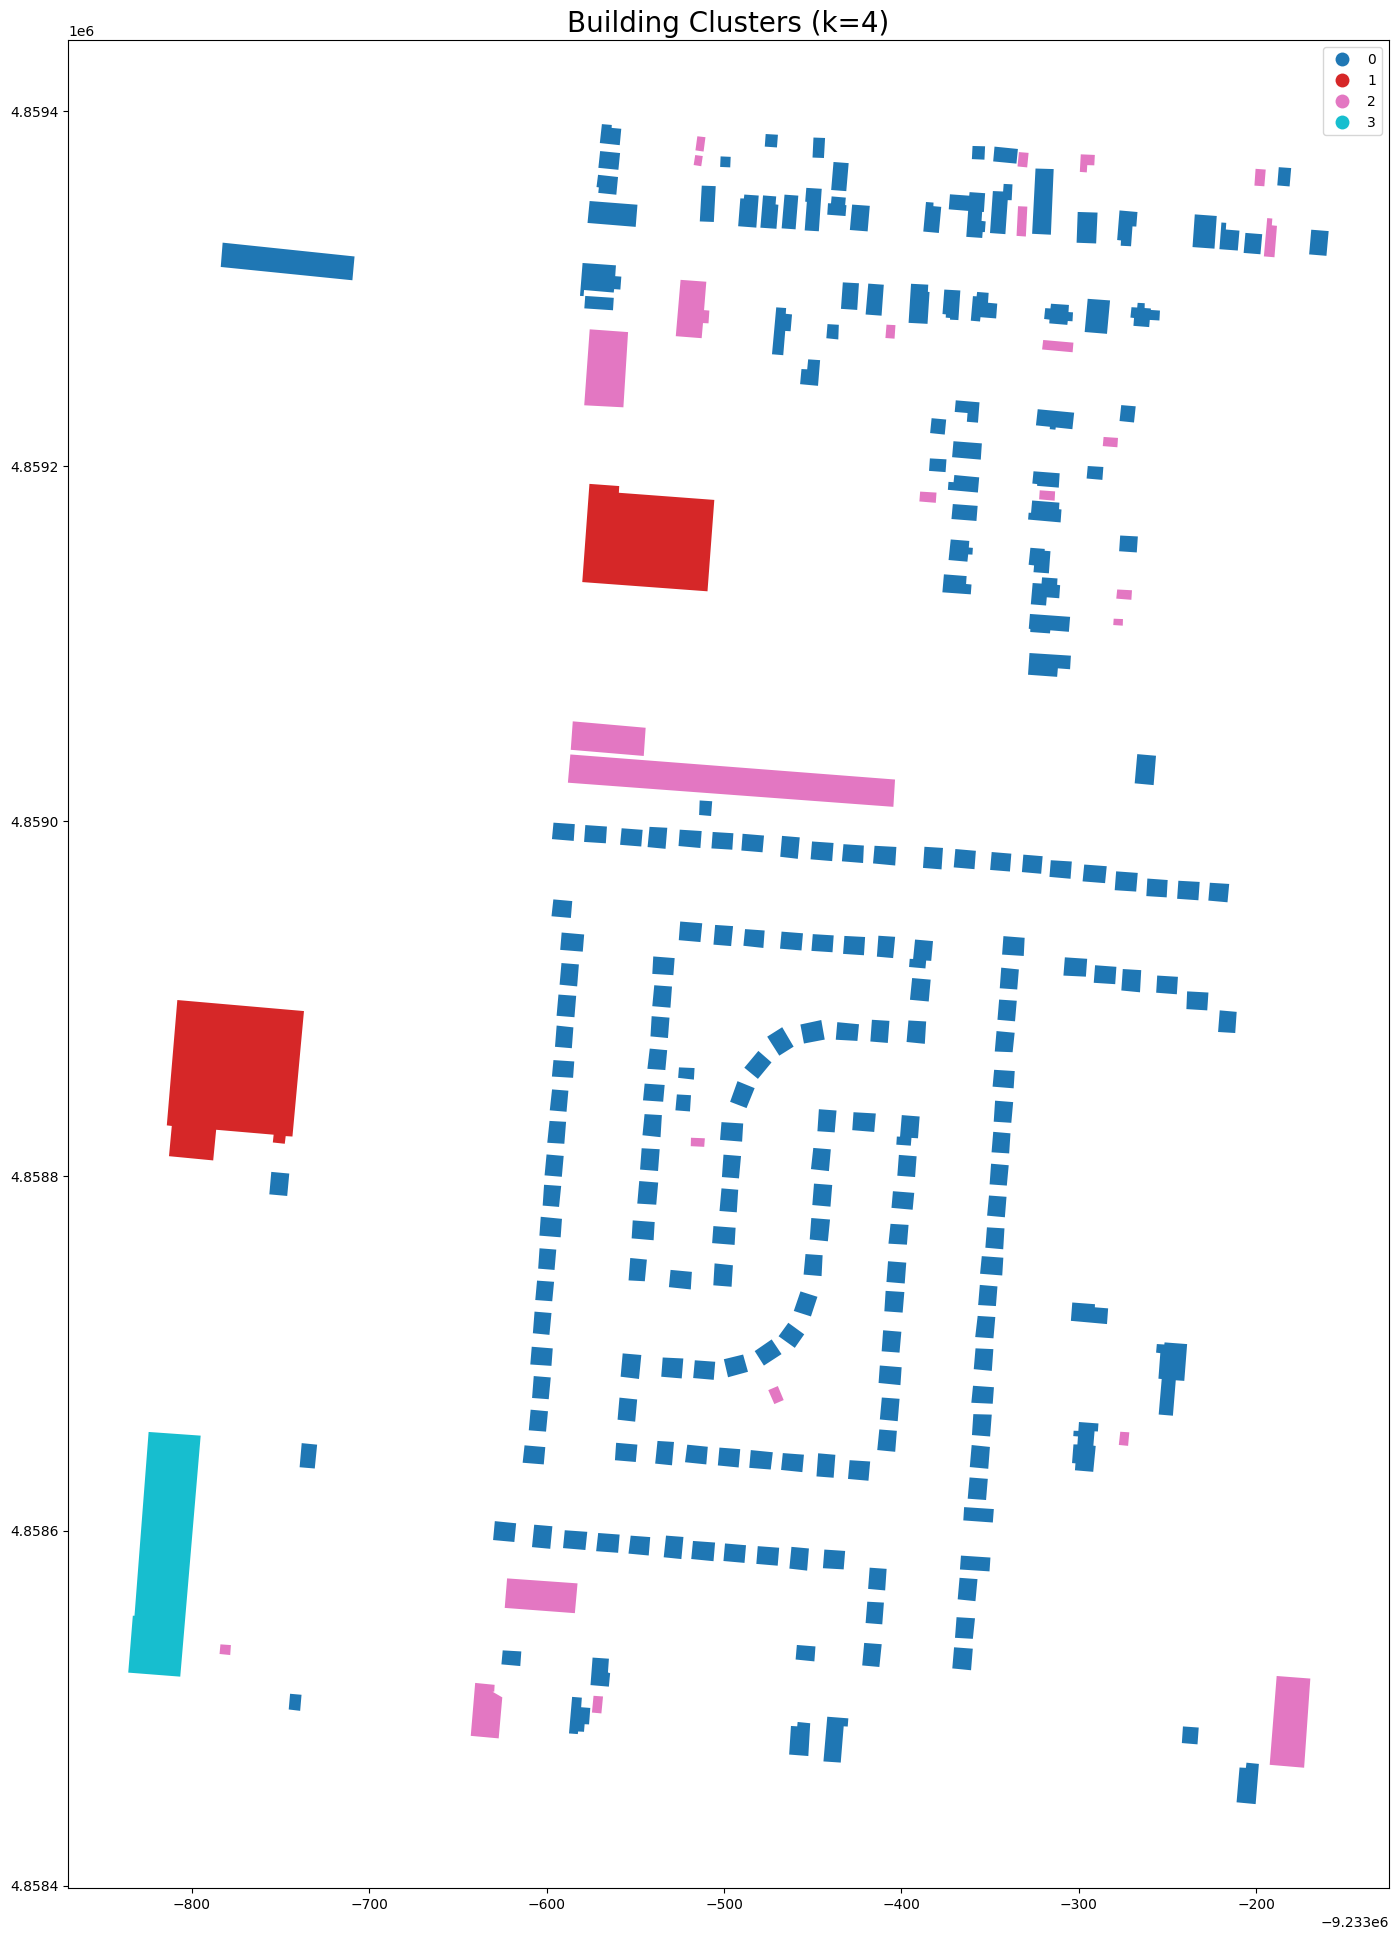

In [29]:
sim_buildings_ext_gdf.plot(column='cluster_4', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=4)", fontsize=20)

- *n*=6

In [30]:
# n = 5
clsutering_5 = SpectralClustering(n_clusters=5, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(kernel_matrix)
y_pred_5 = clsutering_5.labels_.astype(int)
sim_buildings_ext_gdf['cluster_5'] = y_pred_5
sim_buildings_ext_gdf['cluster_5'] = sim_buildings_ext_gdf['cluster_5'].astype('category') # Make the column categorical
sim_buildings_ext_gdf

,blockID,stories,materials,geometry,cluster_2,cluster_3,cluster_4,cluster_5
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",1,2,3,2
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",0,0,2,3
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",0,0,0,4
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",0,0,2,3
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",0,0,0,4
...,...,...,...,...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",0,0,0,0
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",0,0,0,4
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",1,1,1,1
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1...",0,0,0,0


Text(0.5, 1.0, 'Building Clusters (k=5)')

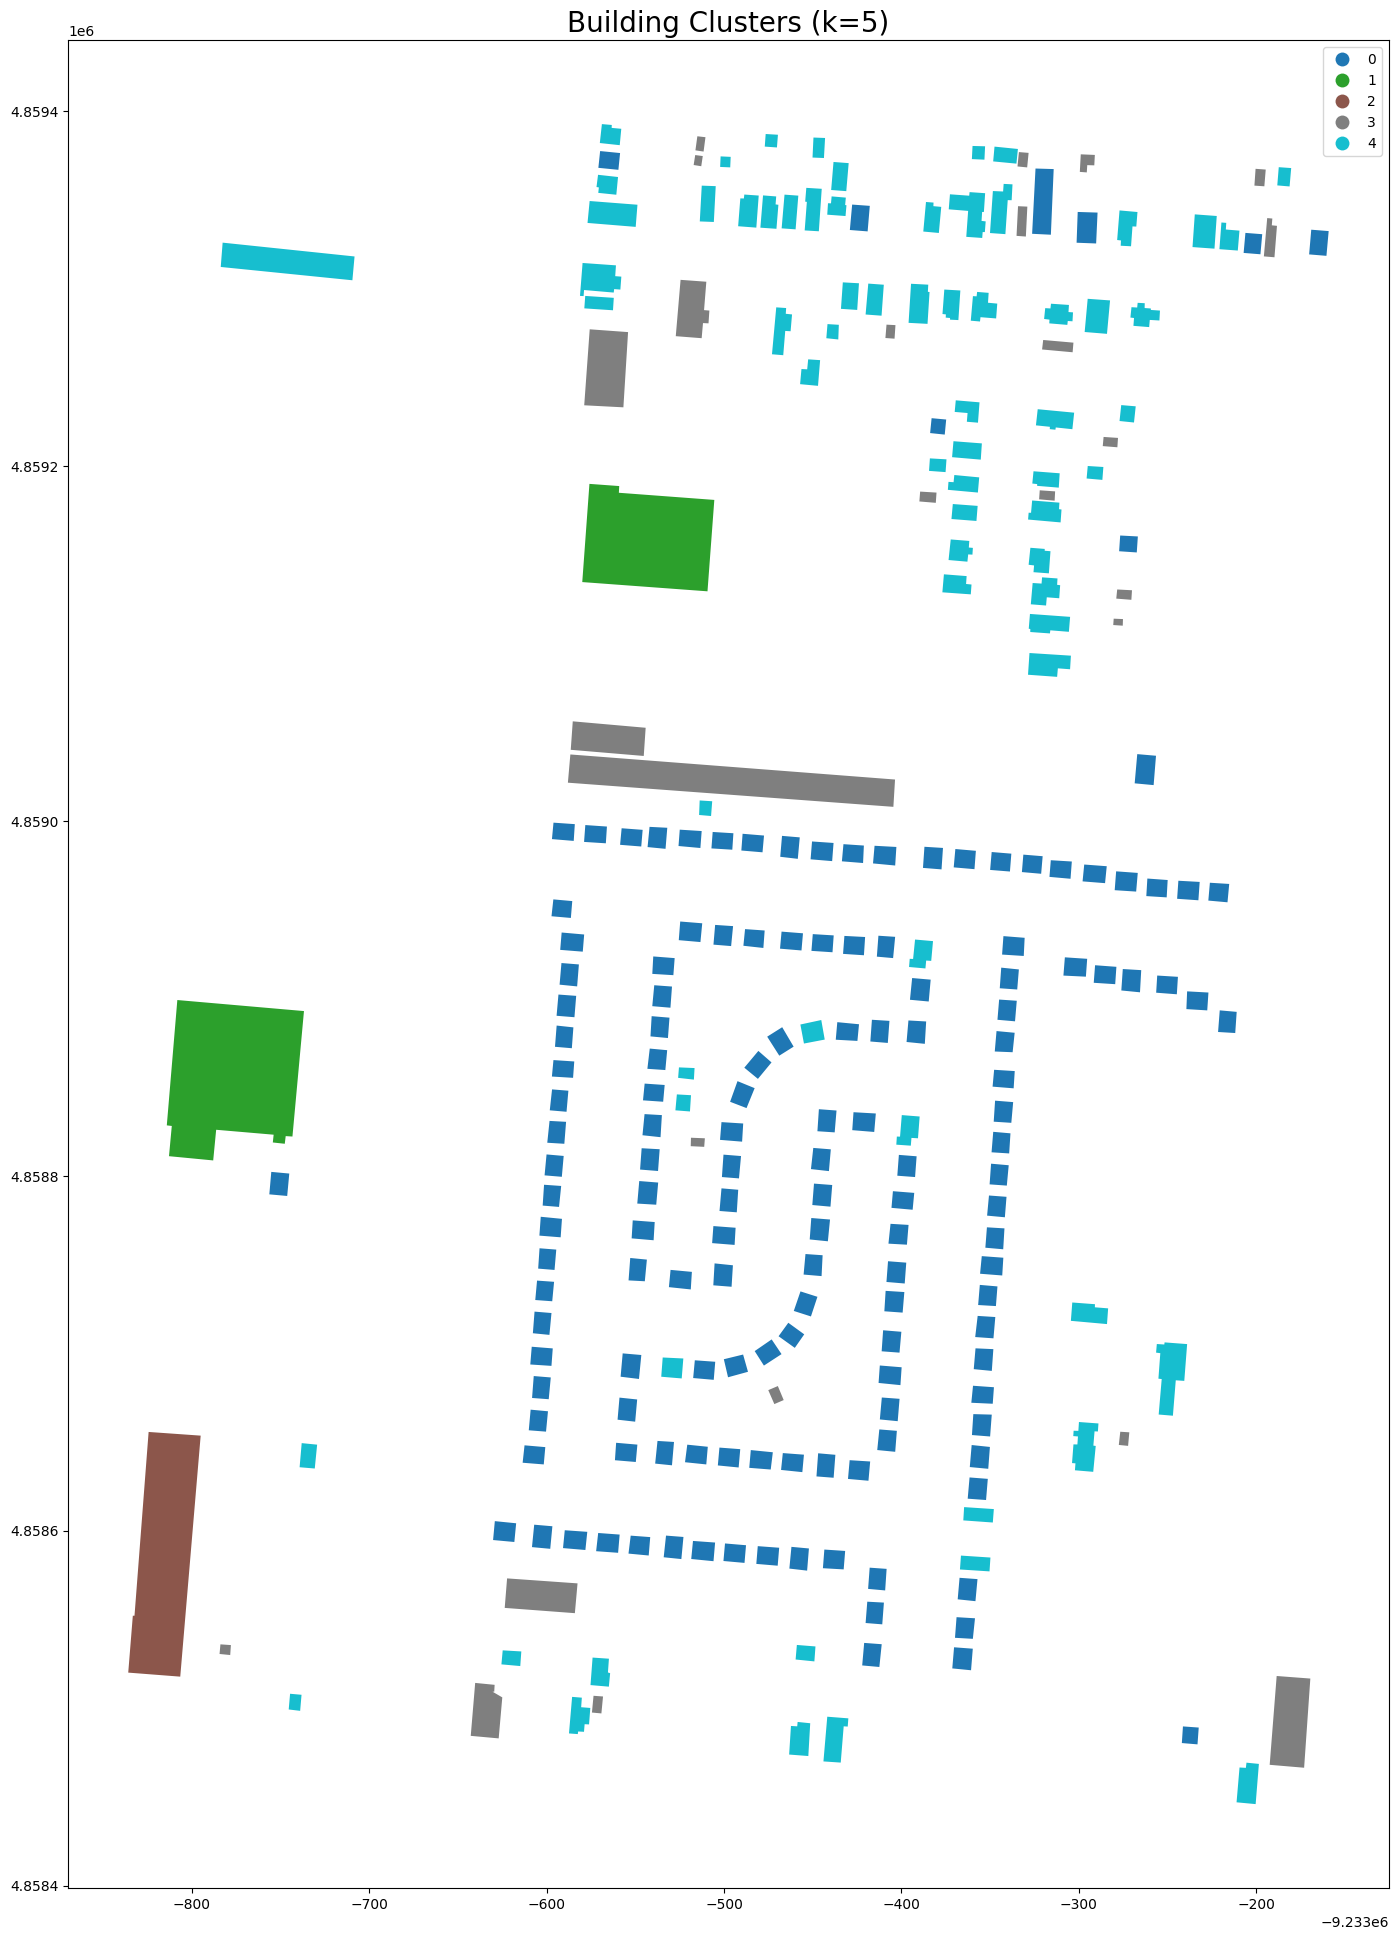

In [31]:
sim_buildings_ext_gdf.plot(column='cluster_5', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=5)", fontsize=20)

## **DEBUGGING...**

In [32]:
#sim_buildings_ext_gdf

In [33]:
# check the number of vertices in each bulding footprint, make sure there is no overlapping vertices issue
len(sim_buildings_ext_gdf.geometry[107].exterior.coords[:-1])

14

In [34]:
# identify buildings for debugging
print(sim_buildings_ext_gdf[sim_buildings_ext_gdf['blockID'] == '738'].index)

Index([149], dtype='int64')


#### **Working with smaller size of footprints**

In [35]:
### function #1: Extract poitns from one polygon
def pts_to_skeleton(geom):
    '''
    This function extracts points from a geometry, converts them into a polygon, and draws the skeleton of a geometry. It returns a skeleton graph of a geometry
    '''
    points = []
    for x, y in geom.boundary.coords[:-1]:
        points.append(sg.Point2(x,y))
    points_to_poly = points[::-1] # make sure it is counter-clockwise
    poly_to_skel = sg.Polygon(points_to_poly)
    skeleton = sg.skeleton.create_interior_straight_skeleton(poly_to_skel)
    return skeleton


### function #2: Convert skeleton graphs to networkx graphs
def skeleton2networkx(skeleton):
    geom_vertices = list(skeleton.vertices)
    geom_edges = list(skeleton.halfedges)

    # create an empty graph with no nodes and no edges
    G=nx.Graph()

    # grow undirected (since it adds up from both direction) graph G by adding edge, done by specifying the vertex id at two ends to determine the edge
    for item in geom_edges:
        if item.is_bisector:
            p1 = item.vertex.id # vertex id
            p2 = item.opposite.vertex.id
            G.add_edge(p1, p2)
    #nx.draw(G, with_labels=True)
    return G

In [36]:
# medial axis and networkx graph
ske_2 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[2])
gs_2 = skeleton2networkx(ske_2)

ske_151 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[151])
gs_151 = skeleton2networkx(ske_151)

ske_155 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[155])
gs_155 = skeleton2networkx(ske_155)

ske_183 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[183])
gs_183 = skeleton2networkx(ske_183)

ske_221 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[221])
gs_221 = skeleton2networkx(ske_221)

ske_224 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[224])
gs_224 = skeleton2networkx(ske_224)

ske_150 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[150])
gs_150 = skeleton2networkx(ske_150)

ske_132 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[132])
gs_132 = skeleton2networkx(ske_132)

ske_250 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[250])
gs_250 = skeleton2networkx(ske_250)

ske_0 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[0])
gs_0 = skeleton2networkx(ske_0)

ske_107 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[107])
gs_107 = skeleton2networkx(ske_107)

ske_87 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[87])
gs_87 = skeleton2networkx(ske_87)

ske_145 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[145])
gs_145 = skeleton2networkx(ske_145)

ske_84 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[84])
gs_84 = skeleton2networkx(ske_84)

ske_123 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[123])
gs_123 = skeleton2networkx(ske_123)

ske_110 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[110])
gs_110 = skeleton2networkx(ske_110)

ske_113 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[113])
gs_113 = skeleton2networkx(ske_113)

ske_240 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[240])
gs_240 = skeleton2networkx(ske_240)

ske_242 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[242])
gs_242 = skeleton2networkx(ske_242)

ske_126 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[126])
gs_126 = skeleton2networkx(ske_126)

ske_144 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[144])
gs_144 = skeleton2networkx(ske_144)

ske_149 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[149])
gs_149 = skeleton2networkx(ske_149)

In [37]:
subset_ske = [ske_2,ske_151,ske_155,ske_183,ske_221,ske_224,ske_150,ske_132,ske_250,ske_0,ske_107,ske_87,ske_145,ske_84,ske_123,ske_110,ske_113,ske_240,ske_242,ske_126,ske_144,ske_149]
len(subset_ske)

22

In [38]:
# computing edge weight
subset_weights = []
for skeleton in subset_ske:
    sub_weights = {}
    for edge in skeleton.halfedges:
        if edge.is_bisector:
            u1_pt = edge.vertex.point
            u2_pt = edge.opposite.vertex.point
            u1_vertex = edge.vertex
            u2_vertex = edge.opposite.vertex
            d_u1u2 = math.sqrt((u2_pt.x()-u1_pt.x())**2 + (u2_pt.y()-u1_pt.y())**2)
            sub_weights[(u1_vertex.id, u2_vertex.id)] = d_u1u2 
    subset_weights.append(sub_weights)


len(subset_weights)

22

In [39]:
subset_weights

[{(8, 0): 9.592372510200464,
  (0, 8): 9.592372510200464,
  (8, 1): 9.477622524738061,
  (1, 8): 9.477622524738061,
  (9, 2): 9.828968775352473,
  (2, 9): 9.828968775352473,
  (9, 3): 9.590794156831556,
  (3, 9): 9.590794156831556,
  (9, 8): 61.051472859698656,
  (8, 9): 61.051472859698656},
 {(8, 0): 10.825321437569102,
  (0, 8): 10.825321437569102,
  (9, 1): 11.216861761842821,
  (1, 9): 11.216861761842821,
  (9, 2): 11.344539218341213,
  (2, 9): 11.344539218341213,
  (8, 3): 10.988968939013212,
  (3, 8): 10.988968939013212,
  (9, 8): 168.03575428291714,
  (8, 9): 168.03575428291714},
 {(16, 0): 3.3279101195897405,
  (0, 16): 3.3279101195897405,
  (23, 1): 5.235058469565962,
  (1, 23): 5.235058469565962,
  (20, 2): 5.155705668105134,
  (2, 20): 5.155705668105134,
  (25, 3): 7.13710399428437,
  (3, 25): 7.13710399428437,
  (24, 4): 7.227778658082617,
  (4, 24): 7.227778658082617,
  (24, 5): 7.17248614836995,
  (5, 24): 7.17248614836995,
  (17, 6): 3.3083565477087227,
  (6, 17): 3.3083

In [40]:
## from networkx graphs to igraph graphs
ig_2 = ig.Graph.from_networkx(gs_2)
ig_151 = ig.Graph.from_networkx(gs_151)
ig_155 = ig.Graph.from_networkx(gs_155)
ig_183 = ig.Graph.from_networkx(gs_183)
ig_221 = ig.Graph.from_networkx(gs_221)
ig_224 = ig.Graph.from_networkx(gs_224)
ig_150 = ig.Graph.from_networkx(gs_150)
ig_132 = ig.Graph.from_networkx(gs_132)
ig_250 = ig.Graph.from_networkx(gs_250)
ig_0 = ig.Graph.from_networkx(gs_0)
ig_107 = ig.Graph.from_networkx(gs_107)
ig_87 = ig.Graph.from_networkx(gs_87)
ig_145 = ig.Graph.from_networkx(gs_145)
ig_84 = ig.Graph.from_networkx(gs_84)
ig_123 = ig.Graph.from_networkx(gs_123)
ig_110 = ig.Graph.from_networkx(gs_110)
ig_113 = ig.Graph.from_networkx(gs_113)
ig_240 = ig.Graph.from_networkx(gs_240)
ig_242 = ig.Graph.from_networkx(gs_242)
ig_126 = ig.Graph.from_networkx(gs_126)
ig_144 = ig.Graph.from_networkx(gs_144)
ig_149 = ig.Graph.from_networkx(gs_149)

subset_igraphs = [ig_2, ig_151, ig_155, ig_183, ig_221, ig_224,
                 ig_150, ig_132, ig_250, ig_0, ig_107, ig_87,
                 ig_145, ig_84, ig_123, ig_110, ig_113, ig_240,
                 ig_242, ig_126, ig_144, ig_149]

len(subset_igraphs)

22

In [41]:
# construct node features
subset_node_ls_dict = []
for skeleton in subset_ske:
    sub_node_ls_dict = {}
    for i in list(skeleton.vertices):
        sub_node_ls_dict[i.id] = i.time
    subset_node_ls_dict.append(sub_node_ls_dict)

subset_node_ls_dict

[{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 6.747976774744137, 9: 6.858177803181223},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 7.717659342542857, 9: 7.970279119009592},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  16: 2.3614898254273764,
  17: 2.4022004055480504,
  20: 3.6962269386643727,
  23: 3.7108423678850366,
  24: 5.103631623907486,
  25: 5.108941533920166},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  16: 2.3371013458572967,
  17: 2.373681225754804,
  20: 3.2312896833802536,
  21: 3.2363647602397236,
  24: 5.060018340113934,
  25: 5.065319324913257},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 4.888695302487665, 9: 4.893198549951605},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 4.911331003065985, 9: 4.917286909022391},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 7.973821542236915, 9: 8.02165529786532},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  12: 8.498801794639068,
  13: 8.537394406231767,
  16: 25.840307066689125,
 

In [42]:
# compute the kernel, num_iterations=4
subset_kernel_matrix = wwl(subset_igraphs,node_features=subset_node_ls_dict, edge_weight=subset_weights, num_iterations=4)

INFO:root:Continuous node features provided, using CONTINUOUS propagation scheme.


weighted_label_sequences: [array([[0.        , 3.37398839, 3.49817468, 3.50367234, 3.50480019],
       [0.        , 3.37398839, 3.49817468, 3.50367234, 3.50480019],
       [0.        , 3.4290889 , 3.5533426 , 3.55690141, 3.55608804],
       [0.        , 3.4290889 , 3.5533426 , 3.55690141, 3.55608804],
       [6.74797677, 3.62236097, 3.50917   , 3.50592804, 3.506669  ],
       [6.8581778 , 3.6775963 , 3.56046022, 3.55527467, 3.55421085]]), array([[0.        , 3.85882967, 3.92146195, 3.92343929, 3.92443193],
       [0.        , 3.98513956, 4.04779779, 4.04778931, 4.04679572],
       [0.        , 3.98513956, 4.04779779, 4.04778931, 4.04679572],
       [0.        , 3.85882967, 3.92146195, 3.92343929, 3.92443193],
       [7.71765934, 3.98409423, 3.92541662, 3.92542457, 3.92635504],
       [7.97027912, 4.11045603, 4.04778082, 4.04580213, 4.04480881]]), array([[0.        , 1.18074491, 1.46009032, 1.60023401, 1.69155516],
       [0.        , 1.85542118, 2.4134795 , 2.59735644, 2.64841778],
   

In [43]:
subset_kernel_matrix

array([[1.00000000e+00, 6.03136941e-01, 3.41659013e-01, 3.32857475e-01,
        4.79060571e-01, 4.80428389e-01, 5.27117521e-01, 1.05433349e-03,
        2.28370596e-03, 3.88085231e-03, 3.19946433e-01, 3.34605586e-01,
        3.87022147e-01, 3.99040713e-01, 3.41007861e-01, 3.86901549e-01,
        3.04678564e-01, 4.17375994e-01, 5.33510983e-01, 3.35188182e-01,
        3.49932965e-01, 4.81478355e-01],
       [6.03136941e-01, 1.00000000e+00, 2.17293903e-01, 2.12101914e-01,
        3.04680800e-01, 3.05550728e-01, 8.52780954e-01, 1.58153593e-03,
        3.41642648e-03, 5.82140985e-03, 2.14464882e-01, 2.12807949e-01,
        2.46144694e-01, 2.53788458e-01, 2.18378222e-01, 2.60495318e-01,
        2.34915316e-01, 2.65449631e-01, 3.74283894e-01, 2.29631213e-01,
        2.22556107e-01, 3.10170054e-01],
       [3.41659013e-01, 2.17293903e-01, 1.00000000e+00, 8.93168464e-01,
        6.02979756e-01, 6.01263023e-01, 1.93463324e-01, 5.60395364e-04,
        1.21382679e-03, 2.06273599e-03, 7.13649208e-01

In [ ]:
#ig_2.vs["_nx_name"]

In [ ]:
# compute the kernel, num_iterations=2
#subset_kernel_matrix_it2 = wwl(subset_igraphs,node_features=subset_node_ls_dict, edge_weight=subset_weights, num_iterations=2)
#subset_kernel_matrix_it5 = wwl(subset_igraphs,node_features=subset_node_ls_dict, edge_weight=subset_weights, num_iterations=5)

In [ ]:
#subset_kernel_matrix
#subset_kernel_matrix_it2
#subset_kernel_matrix_it5

In [44]:
# construct laplacian matrix, L = D - A
# compute D
subset_D = np.diag(subset_kernel_matrix.sum(axis=1))
print(subset_D)
# subset_D_it2 = np.diag(subset_kernel_matrix_it2.sum(axis=1))
# print(subset_D_it2)
# subset_D_it5 = np.diag(subset_kernel_matrix_it5.sum(axis=1))
# print(subset_D_it5)

[[ 8.36216813  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          6.54945035  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         12.28076843  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         12.16809888  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0

In [45]:
subset_L = subset_D - subset_kernel_matrix
print(subset_L)
# subset_L_it2 = subset_D_it2 - subset_kernel_matrix_it2
# print(subset_L_it2)
# subset_L_it5 = subset_D_it5 - subset_kernel_matrix_it5
# print(subset_L_it5)

[[ 7.36216813e+00 -6.03136941e-01 -3.41659013e-01 -3.32857475e-01
  -4.79060571e-01 -4.80428389e-01 -5.27117521e-01 -1.05433349e-03
  -2.28370596e-03 -3.88085231e-03 -3.19946433e-01 -3.34605586e-01
  -3.87022147e-01 -3.99040713e-01 -3.41007861e-01 -3.86901549e-01
  -3.04678564e-01 -4.17375994e-01 -5.33510983e-01 -3.35188182e-01
  -3.49932965e-01 -4.81478355e-01]
 [-6.03136941e-01  5.54945035e+00 -2.17293903e-01 -2.12101914e-01
  -3.04680800e-01 -3.05550728e-01 -8.52780954e-01 -1.58153593e-03
  -3.41642648e-03 -5.82140985e-03 -2.14464882e-01 -2.12807949e-01
  -2.46144694e-01 -2.53788458e-01 -2.18378222e-01 -2.60495318e-01
  -2.34915316e-01 -2.65449631e-01 -3.74283894e-01 -2.29631213e-01
  -2.22556107e-01 -3.10170054e-01]
 [-3.41659013e-01 -2.17293903e-01  1.12807684e+01 -8.93168464e-01
  -6.02979756e-01 -6.01263023e-01 -1.93463324e-01 -5.60395364e-04
  -1.21382679e-03 -2.06273599e-03 -7.13649208e-01 -8.52104162e-01
  -7.78510506e-01 -7.54238093e-01 -8.91882061e-01 -6.43343464e-01
  -3.8

Optimal number of clusters: [ 2 21 20  3 19]


/tmp/ipykernel_2350/3834166893.py:27: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)


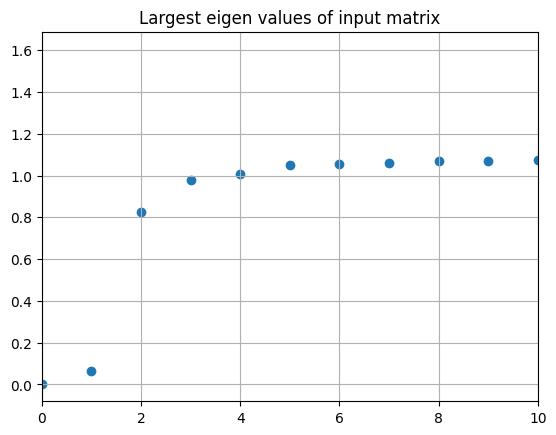

In [46]:
# k-mean cluster
k, _, _ = eigenDecomposition(subset_kernel_matrix)
print(f"Optimal number of clusters: {k}")
# k, _, _ = eigenDecomposition(subset_kernel_matrix_it2)
# print(f"Optimal number of clusters: {k}")
# k, _, _ = eigenDecomposition(subset_kernel_matrix_it5)
# print(f"Optimal number of clusters: {k}")

In [47]:
# subset from sim_buildings_ext_gdf
subset_gdf = sim_buildings_ext_gdf.iloc[[2,151,155,183,221,224,150,132,250,0,107,87,145,84,123,110,113,240,242,126,144,149]]
subset_gdf_modified = subset_gdf.drop(['cluster_2','cluster_3','cluster_4','cluster_5'], axis=1)
subset_gdf_modified

,blockID,stories,materials,geometry
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5..."
151,760b,None,concrete and cinder block,"POLYGON ((-9233404.567 4859007.961, -9233587.9..."
155,791,1.5,frame or wood,"POLYGON ((-9233395.35 4858922.309, -9233393.44..."
183,827_b,1.5,frame or wood,"POLYGON ((-9233402.605 4858822.141, -9233400.8..."
221,873,1.5,frame or wood,"POLYGON ((-9233608.992 4858668.227, -9233599.2..."
224,879,1.5,frame or wood,"POLYGON ((-9233612.432 4858648.128, -9233600.7..."
150,760a,1,"adobe, metal or iron","POLYGON ((-9233545.25 4859036.632, -9233586.38..."
132,700,None,concrete and cinder block,"POLYGON ((-9233579.899 4859134.625, -9233575.8..."
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80..."
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24..."


Text(0.5, 1.0, 'Subset Building Clusters (k=2)')

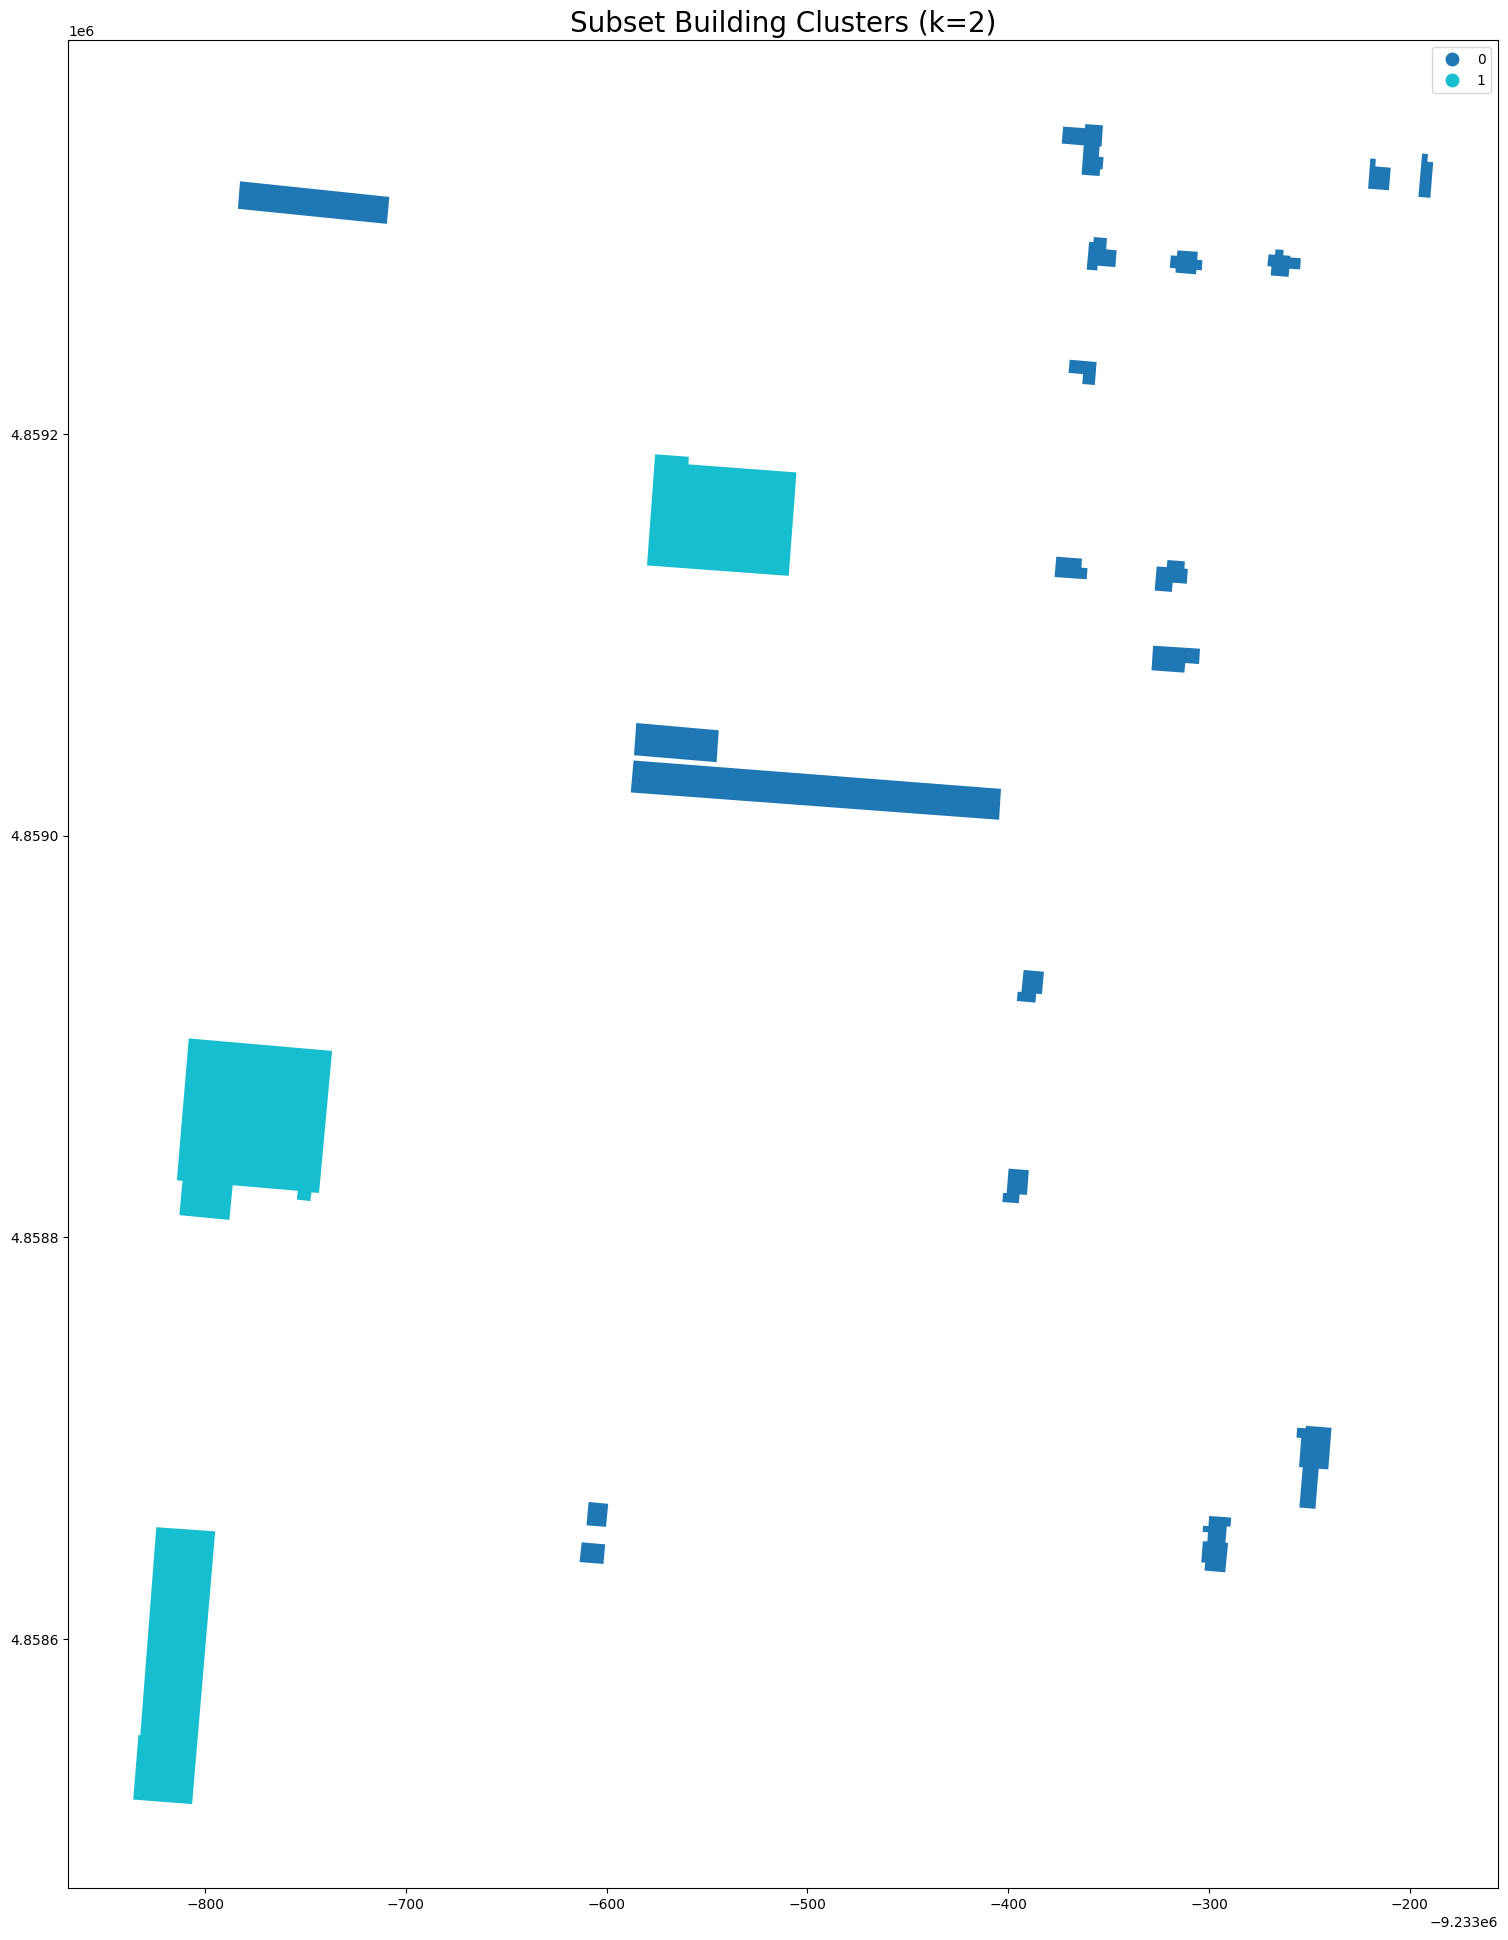

In [48]:
n = 2
subset_clsutering_2 = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(subset_kernel_matrix)
subset_y_pred_2 = subset_clsutering_2.labels_.astype(int)
subset_gdf_modified['sub_cluster_2'] = subset_y_pred_2
subset_gdf_modified['sub_cluster_2'] = subset_gdf_modified['sub_cluster_2'].astype('category') # Make the column categorical
subset_gdf_modified.plot(column='sub_cluster_2', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Subset Building Clusters (k=2)", fontsize=20)

# # n=2, num_it=2
# subset_clsutering_2_it2 = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(subset_kernel_matrix_it2)
# subset_y_pred_2_it2 = subset_clsutering_2_it2.labels_.astype(int)
# subset_gdf_modified['sub_cluster_2_it2'] = subset_y_pred_2_it2
# subset_gdf_modified['sub_cluster_2_it2'] = subset_gdf_modified['sub_cluster_2_it2'].astype('category') # Make the column categorical
# subset_gdf_modified.plot(column='sub_cluster_2_it2', cmap='tab10', legend=True, figsize=(24,24))
# plt.title("Subset Building Clusters (k=2, num_it=2)", fontsize=20)

# # n=2, num_it=5
# subset_clsutering_2_it5 = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(subset_kernel_matrix_it5)
# subset_y_pred_2_it5 = subset_clsutering_2_it5.labels_.astype(int)
# subset_gdf_modified['sub_cluster_2_it5'] = subset_y_pred_2_it5
# subset_gdf_modified['sub_cluster_2_it5'] = subset_gdf_modified['sub_cluster_2_it5'].astype('category') # Make the column categorical
# subset_gdf_modified.plot(column='sub_cluster_2_it5', cmap='tab10', legend=True, figsize=(24,24))
# plt.title("Subset Building Clusters (k=2, num_it=5)", fontsize=20)

Text(0.5, 1.0, 'Subset Building Clusters (k=3)')

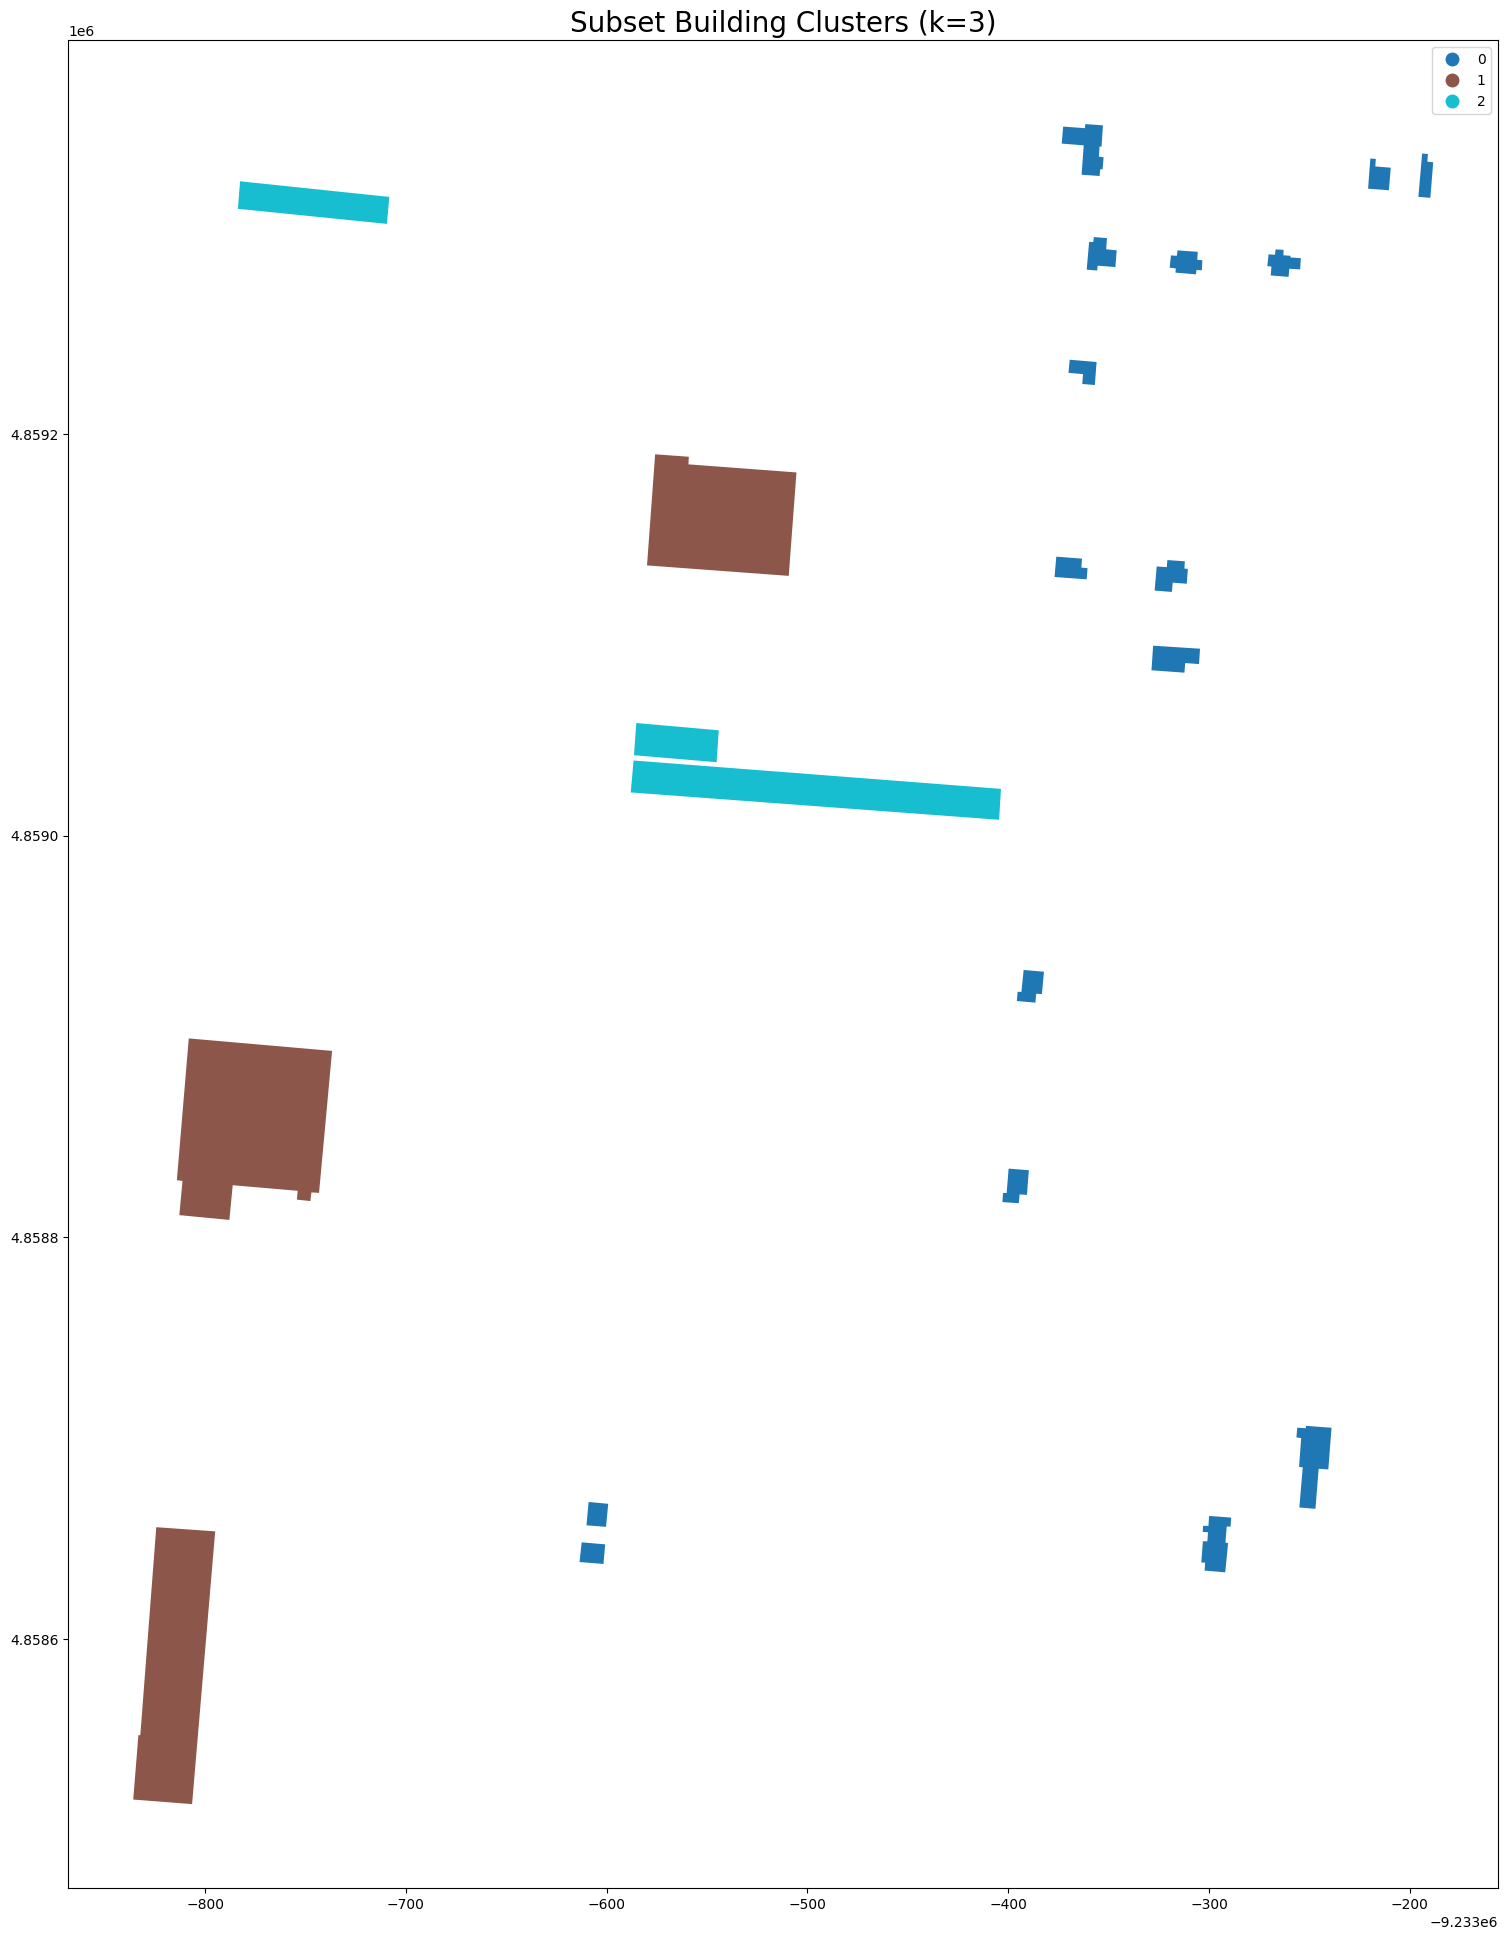

In [49]:
n = 3
subset_clsutering_3 = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(subset_kernel_matrix)
subset_y_pred_3 = subset_clsutering_3.labels_.astype(int)
subset_gdf_modified['sub_cluster_3'] = subset_y_pred_3
subset_gdf_modified['sub_cluster_3'] = subset_gdf_modified['sub_cluster_3'].astype('category') # Make the column categorical
subset_gdf_modified.plot(column='sub_cluster_3', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Subset Building Clusters (k=3)", fontsize=20)

# # n = 3, num_it=2
# subset_clsutering_3_it2 = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(subset_kernel_matrix_it2)
# subset_y_pred_3_it2 = subset_clsutering_3_it2.labels_.astype(int)
# subset_gdf_modified['sub_cluster_3_it2'] = subset_y_pred_3_it2
# subset_gdf_modified['sub_cluster_3_it2'] = subset_gdf_modified['sub_cluster_3_it2'].astype('category') # Make the column categorical
# subset_gdf_modified.plot(column='sub_cluster_3_it2', cmap='tab10', legend=True, figsize=(24,24))
# plt.title("Subset Building Clusters (k=3, num_it=2)", fontsize=20)

# # n = 3, num_it=5
# subset_clsutering_3_it5 = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(subset_kernel_matrix_it5)
# subset_y_pred_3_it5 = subset_clsutering_3_it5.labels_.astype(int)
# subset_gdf_modified['sub_cluster_3_it5'] = subset_y_pred_3_it5
# subset_gdf_modified['sub_cluster_3_it5'] = subset_gdf_modified['sub_cluster_3_it5'].astype('category') # Make the column categorical
# subset_gdf_modified.plot(column='sub_cluster_3_it5', cmap='tab10', legend=True, figsize=(24,24))
# plt.title("Subset Building Clusters (k=3, num_it=5)", fontsize=20)

Text(0.5, 1.0, 'Subset Building Clusters (k=4)')

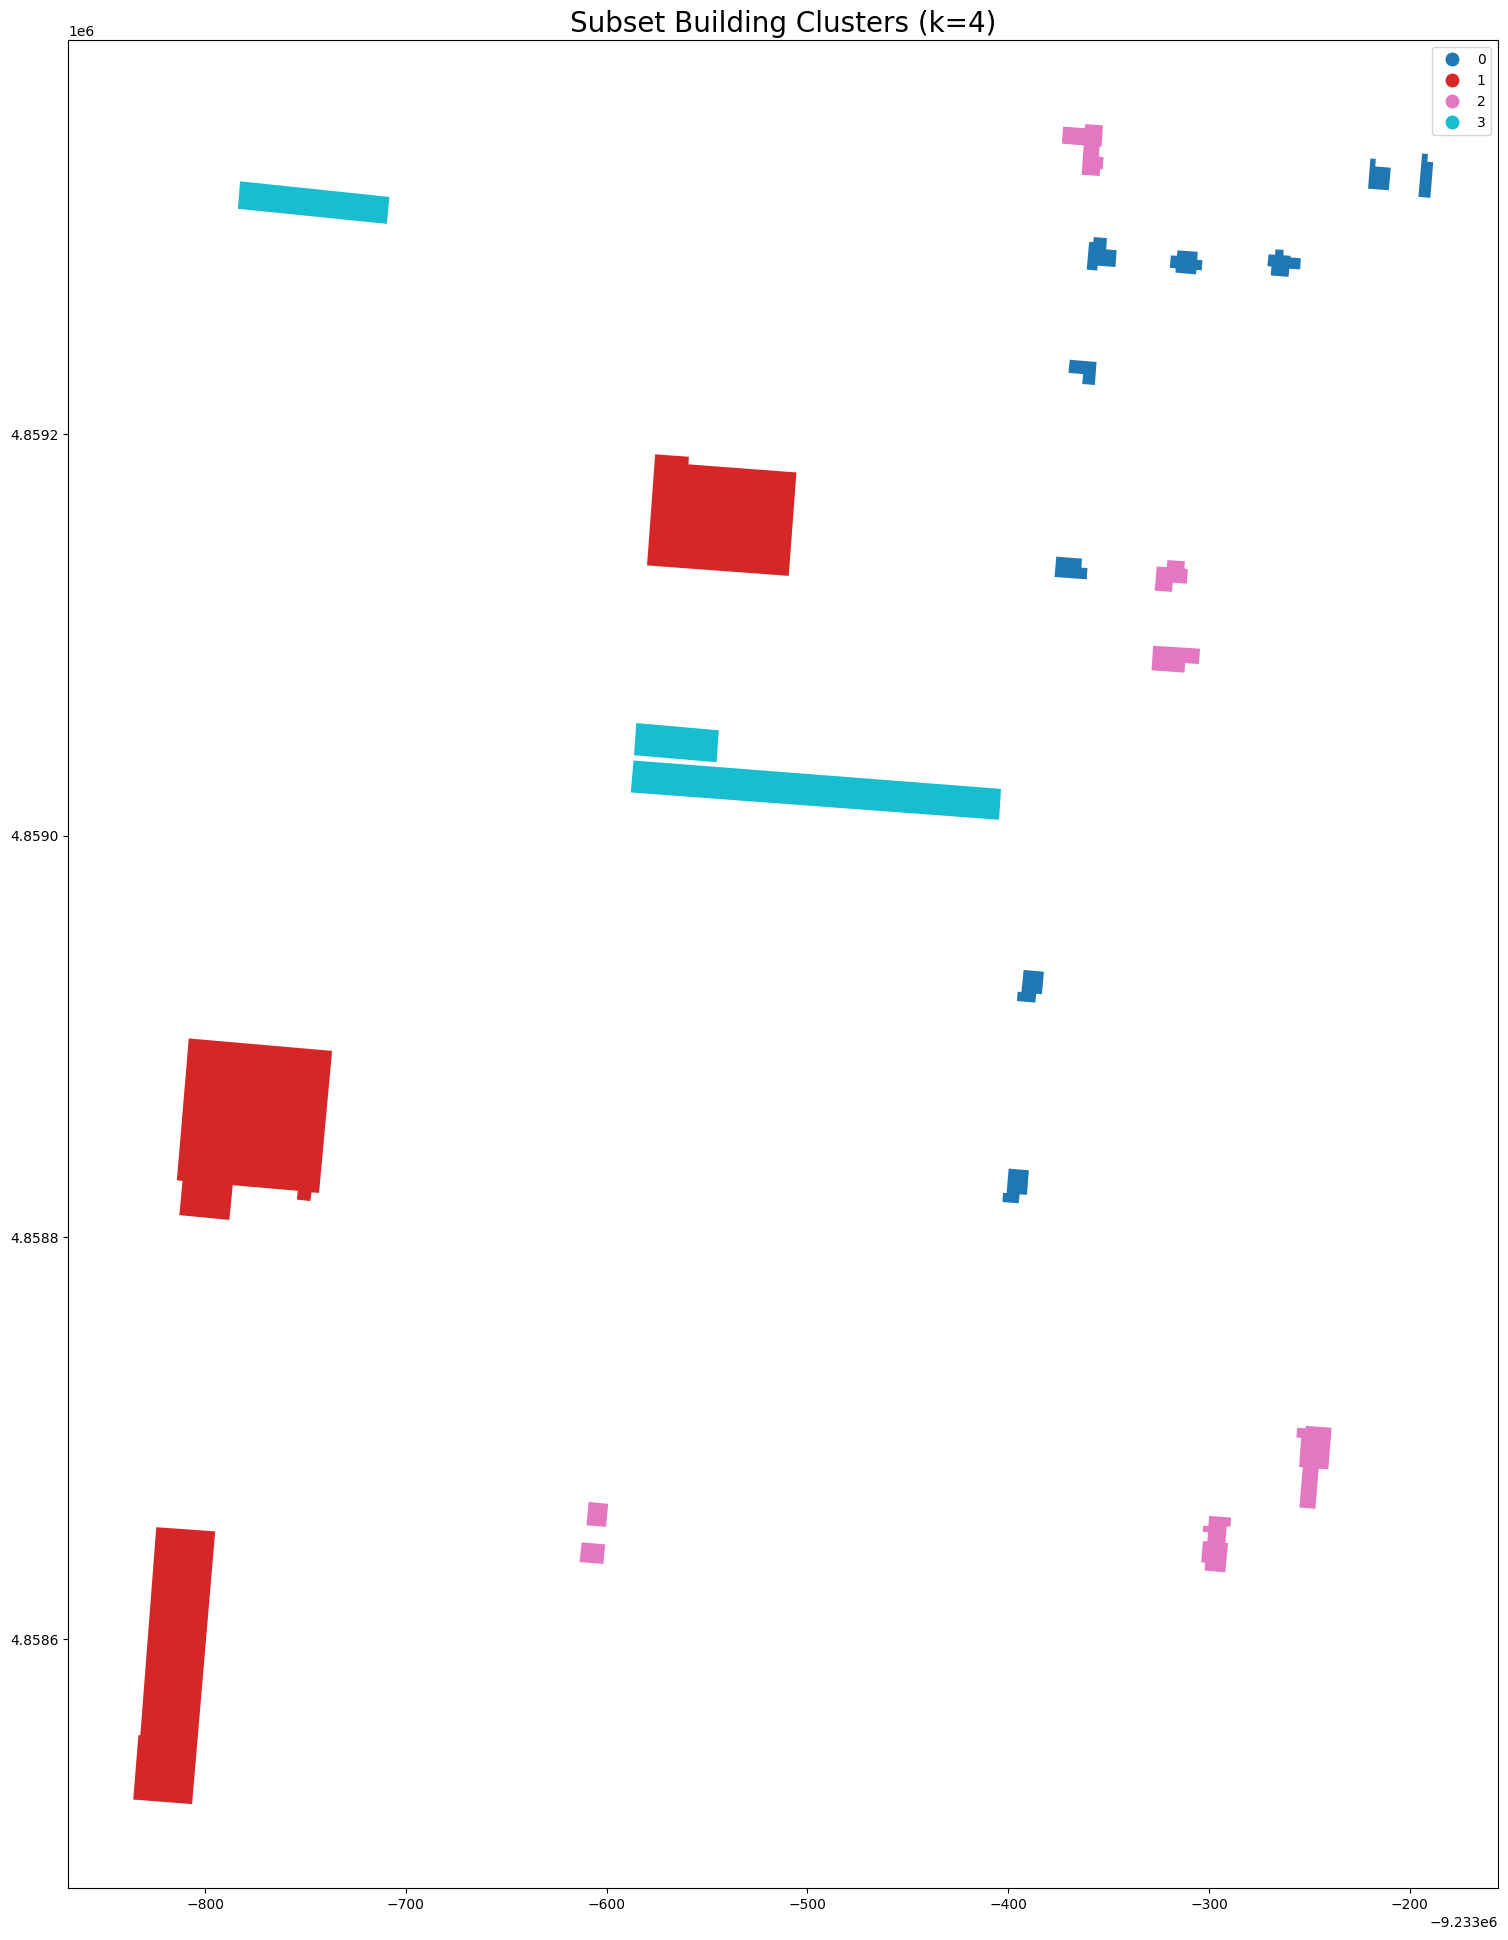

In [50]:
n = 4
subset_clsutering_4 = SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(subset_kernel_matrix)
subset_y_pred_4 = subset_clsutering_4.labels_.astype(int)
subset_gdf_modified['sub_cluster_4'] = subset_y_pred_4
subset_gdf_modified['sub_cluster_4'] = subset_gdf_modified['sub_cluster_4'].astype('category') # Make the column categorical
subset_gdf_modified.plot(column='sub_cluster_4', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Subset Building Clusters (k=4)", fontsize=20)

# # n = 4, num_it=2
# subset_clsutering_4_it2 = SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(subset_kernel_matrix_it2)
# subset_y_pred_4_it2 = subset_clsutering_4_it2.labels_.astype(int)
# subset_gdf_modified['sub_cluster_4_it2'] = subset_y_pred_4_it2
# subset_gdf_modified['sub_cluster_4_it2'] = subset_gdf_modified['sub_cluster_4_it2'].astype('category') # Make the column categorical
# subset_gdf_modified.plot(column='sub_cluster_4_it2', cmap='tab10', legend=True, figsize=(24,24))
# plt.title("Subset Building Clusters (k=4, num_it=2)", fontsize=20)

# # n = 4, num_it=5
# subset_clsutering_4_it5 = SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(subset_kernel_matrix_it5)
# subset_y_pred_4_it5 = subset_clsutering_4_it5.labels_.astype(int)
# subset_gdf_modified['sub_cluster_4_it5'] = subset_y_pred_4_it5
# subset_gdf_modified['sub_cluster_4_it5'] = subset_gdf_modified['sub_cluster_4_it5'].astype('category') # Make the column categorical
# subset_gdf_modified.plot(column='sub_cluster_4_it5', cmap='tab10', legend=True, figsize=(24,24))
# plt.title("Subset Building Clusters (k=4, num_it=5)", fontsize=20)